# [TUM - miniprojekt] Przebieg procesu uczenia dla sieci przy użyciu różnych algorytmów optymalizacji
## Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395)

In [1]:
# %pip install torch torchvision tqdm pandas matplotlib seaborn

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:
DATASET_PATH: str = "./datasets"
MODEL_PATH: str = "./models"
RESULT_PATH: str = "./results"

BATCH_SIZE: int = 4

In [4]:
def get_dataset(dataset, batch_size: int = BATCH_SIZE) -> tuple:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=True)
    valid_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=False)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [5]:
datasets = {
    "FashionMNIST": torchvision.datasets.FashionMNIST,
    "MNIST": torchvision.datasets.MNIST,
}

In [6]:
device = torch.device(
    "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
)
print(device)


class CNNClassifier(nn.Module):
    def __init__(self, number_of_channels: int = 1, number_of_classes: int = 10) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(number_of_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_of_classes)

    def forward(self, x) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mps


In [7]:
optimizers = {
    "SGD": optim.SGD,
    "AdaGrad": optim.Adagrad,
    "Adam": optim.Adam,
    "AdamW": optim.AdamW,
    "RMSprop": optim.RMSprop,
}

In [8]:
loss_fn = nn.CrossEntropyLoss()


def train_epoch(model, train_loader, optimizer, lr: float = 1e-3) -> float:
    model.train()
    optimizer = optimizer(model.parameters(), lr=lr)

    running_loss = 0.0
    avg_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            avg_loss = running_loss / 1000
            print(f"[{i + 1:5d}] loss: {avg_loss:.3f}")
            running_loss = 0.0

    return avg_loss


def valid_epoch(model, valid_loader) -> float:
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

    avg_loss = running_loss / (i + 1)
    return avg_loss

In [9]:
NUMBER_OF_EPOCHS: int = 100

In [10]:
for dataset_name, dataset in datasets.items():
    print(f"DATASET: {dataset_name}")
    train_loader, valid_loader = get_dataset(dataset)

    for optimizer_name, optimizer in optimizers.items():
        print(f"OPTIMIZER: {optimizer_name}")

        model = CNNClassifier()
        model.to(device)

        best_vloss = np.inf

        results: list = []

        for epoch_number in range(NUMBER_OF_EPOCHS):
            print(f"EPOCH: {epoch_number + 1} / {NUMBER_OF_EPOCHS}")

            avg_loss = train_epoch(model, train_loader, optimizer)

            avg_vloss = valid_epoch(model, valid_loader)

            results.append(
                {
                    "epoch": epoch_number,
                    "train_loss": avg_loss,
                    "valid_loss": avg_vloss,
                }
            )

            print(f"Train Loss: {avg_loss:.3f}, Valid Loss: {avg_vloss:.3f}")

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                if not os.path.exists(MODEL_PATH):
                    os.makedirs(MODEL_PATH)
                torch.save(
                    model.state_dict(), f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth"
                )
            else:
                print(
                    f"Early stopping (no improvement in validation loss in epoch {epoch_number + 1})"
                )
                break

        results_df = pd.DataFrame(results)
        if not os.path.exists(RESULT_PATH):
            os.makedirs(RESULT_PATH)
        results_df.to_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv", index=False)

DATASET: FashionMNIST
OPTIMIZER: SGD
EPOCH: 1 / 100


  7%|▋         | 1060/15000 [00:02<00:36, 380.78it/s]

[ 1000] loss: 2.301


 14%|█▍        | 2081/15000 [00:05<00:31, 407.65it/s]

[ 2000] loss: 2.293


 20%|██        | 3067/15000 [00:07<00:29, 406.29it/s]

[ 3000] loss: 2.283


 27%|██▋       | 4052/15000 [00:10<00:27, 403.92it/s]

[ 4000] loss: 2.257


 34%|███▍      | 5075/15000 [00:12<00:25, 391.71it/s]

[ 5000] loss: 2.188


 40%|████      | 6062/15000 [00:15<00:21, 407.47it/s]

[ 6000] loss: 1.872


 47%|████▋     | 7048/15000 [00:17<00:19, 404.35it/s]

[ 7000] loss: 1.255


 54%|█████▍    | 8074/15000 [00:20<00:17, 406.66it/s]

[ 8000] loss: 0.969


 60%|██████    | 9061/15000 [00:22<00:14, 404.39it/s]

[ 9000] loss: 0.872


 67%|██████▋   | 10047/15000 [00:25<00:12, 406.71it/s]

[10000] loss: 0.822


 74%|███████▍  | 11073/15000 [00:27<00:09, 406.03it/s]

[11000] loss: 0.768


 80%|████████  | 12050/15000 [00:30<00:07, 378.39it/s]

[12000] loss: 0.775


 87%|████████▋ | 13065/15000 [00:33<00:05, 359.20it/s]

[13000] loss: 0.742


 94%|█████████▎| 14040/15000 [00:35<00:02, 384.63it/s]

[14000] loss: 0.702


100%|██████████| 15000/15000 [00:38<00:00, 390.44it/s]


[15000] loss: 0.713


100%|██████████| 2500/2500 [00:03<00:00, 763.19it/s]


Train Loss: 0.713, Valid Loss: 0.718
EPOCH: 2 / 100


  7%|▋         | 1067/15000 [00:02<00:38, 362.25it/s]

[ 1000] loss: 0.696


 14%|█▍        | 2070/15000 [00:05<00:36, 358.13it/s]

[ 2000] loss: 0.651


 20%|██        | 3058/15000 [00:08<00:32, 363.70it/s]

[ 3000] loss: 0.652


 27%|██▋       | 4060/15000 [00:11<00:27, 400.29it/s]

[ 4000] loss: 0.642


 34%|███▎      | 5035/15000 [00:13<00:28, 352.73it/s]

[ 5000] loss: 0.665


 40%|████      | 6073/15000 [00:16<00:23, 382.80it/s]

[ 6000] loss: 0.648


 47%|████▋     | 7055/15000 [00:18<00:19, 405.84it/s]

[ 7000] loss: 0.625


 54%|█████▍    | 8077/15000 [00:21<00:17, 405.64it/s]

[ 8000] loss: 0.600


 60%|██████    | 9066/15000 [00:23<00:14, 409.70it/s]

[ 9000] loss: 0.597


 67%|██████▋   | 10065/15000 [00:26<00:12, 408.48it/s]

[10000] loss: 0.606


 74%|███████▎  | 11053/15000 [00:28<00:09, 406.50it/s]

[11000] loss: 0.611


 80%|████████  | 12042/15000 [00:30<00:07, 407.37it/s]

[12000] loss: 0.583


 87%|████████▋ | 13074/15000 [00:33<00:04, 409.83it/s]

[13000] loss: 0.586


 94%|█████████▎| 14060/15000 [00:35<00:02, 405.91it/s]

[14000] loss: 0.577


100%|██████████| 15000/15000 [00:38<00:00, 392.40it/s]


[15000] loss: 0.562


100%|██████████| 2500/2500 [00:02<00:00, 849.09it/s]


Train Loss: 0.562, Valid Loss: 0.567
EPOCH: 3 / 100


  7%|▋         | 1074/15000 [00:02<00:33, 410.33it/s]

[ 1000] loss: 0.543


 14%|█▍        | 2063/15000 [00:05<00:31, 407.49it/s]

[ 2000] loss: 0.560


 20%|██        | 3050/15000 [00:07<00:30, 396.92it/s]

[ 3000] loss: 0.547


 27%|██▋       | 4080/15000 [00:10<00:26, 410.29it/s]

[ 4000] loss: 0.535


 34%|███▍      | 5073/15000 [00:12<00:24, 410.21it/s]

[ 5000] loss: 0.547


 40%|████      | 6070/15000 [00:14<00:21, 408.38it/s]

[ 6000] loss: 0.526


 47%|████▋     | 7056/15000 [00:17<00:19, 403.87it/s]

[ 7000] loss: 0.516


 54%|█████▎    | 8047/15000 [00:19<00:17, 407.31it/s]

[ 8000] loss: 0.489


 60%|██████    | 9075/15000 [00:22<00:14, 408.49it/s]

[ 9000] loss: 0.517


 67%|██████▋   | 10068/15000 [00:24<00:12, 407.28it/s]

[10000] loss: 0.497


 74%|███████▎  | 11055/15000 [00:27<00:09, 403.60it/s]

[11000] loss: 0.515


 80%|████████  | 12051/15000 [00:29<00:07, 408.61it/s]

[12000] loss: 0.471


 87%|████████▋ | 13078/15000 [00:32<00:04, 404.29it/s]

[13000] loss: 0.527


 94%|█████████▍| 14067/15000 [00:34<00:02, 407.00it/s]

[14000] loss: 0.529


100%|██████████| 15000/15000 [00:36<00:00, 405.86it/s]


[15000] loss: 0.483


100%|██████████| 2500/2500 [00:02<00:00, 846.36it/s]


Train Loss: 0.483, Valid Loss: 0.498
EPOCH: 4 / 100


  7%|▋         | 1075/15000 [00:02<00:33, 413.04it/s]

[ 1000] loss: 0.500


 14%|█▍        | 2074/15000 [00:05<00:31, 409.47it/s]

[ 2000] loss: 0.469


 20%|██        | 3063/15000 [00:07<00:29, 405.18it/s]

[ 3000] loss: 0.475


 27%|██▋       | 4051/15000 [00:09<00:26, 406.18it/s]

[ 4000] loss: 0.494


 34%|███▎      | 5044/15000 [00:12<00:24, 404.64it/s]

[ 5000] loss: 0.483


 40%|████      | 6072/15000 [00:14<00:22, 398.37it/s]

[ 6000] loss: 0.473


 47%|████▋     | 7054/15000 [00:17<00:19, 406.69it/s]

[ 7000] loss: 0.448


 54%|█████▍    | 8079/15000 [00:19<00:17, 404.50it/s]

[ 8000] loss: 0.451


 60%|██████    | 9068/15000 [00:22<00:14, 406.83it/s]

[ 9000] loss: 0.458


 67%|██████▋   | 10060/15000 [00:24<00:12, 408.86it/s]

[10000] loss: 0.450


 74%|███████▎  | 11049/15000 [00:27<00:09, 406.51it/s]

[11000] loss: 0.455


 81%|████████  | 12076/15000 [00:29<00:07, 402.62it/s]

[12000] loss: 0.450


 87%|████████▋ | 13063/15000 [00:32<00:04, 407.15it/s]

[13000] loss: 0.469


 94%|█████████▎| 14049/15000 [00:34<00:02, 406.74it/s]

[14000] loss: 0.454


100%|██████████| 15000/15000 [00:36<00:00, 405.71it/s]


[15000] loss: 0.457


100%|██████████| 2500/2500 [00:02<00:00, 852.50it/s]


Train Loss: 0.457, Valid Loss: 0.456
EPOCH: 5 / 100


  7%|▋         | 1074/15000 [00:02<00:34, 407.69it/s]

[ 1000] loss: 0.438


 14%|█▎        | 2059/15000 [00:05<00:31, 405.76it/s]

[ 2000] loss: 0.428


 20%|██        | 3049/15000 [00:07<00:29, 410.45it/s]

[ 3000] loss: 0.446


 27%|██▋       | 4042/15000 [00:09<00:27, 405.36it/s]

[ 4000] loss: 0.430


 34%|███▍      | 5073/15000 [00:12<00:24, 408.06it/s]

[ 5000] loss: 0.431


 40%|████      | 6065/15000 [00:14<00:21, 409.11it/s]

[ 6000] loss: 0.457


 47%|████▋     | 7055/15000 [00:17<00:19, 409.06it/s]

[ 7000] loss: 0.446


 54%|█████▍    | 8081/15000 [00:19<00:17, 405.21it/s]

[ 8000] loss: 0.405


 60%|██████    | 9070/15000 [00:22<00:14, 404.39it/s]

[ 9000] loss: 0.431


 67%|██████▋   | 10062/15000 [00:24<00:12, 408.34it/s]

[10000] loss: 0.417


 74%|███████▎  | 11052/15000 [00:27<00:09, 407.30it/s]

[11000] loss: 0.426


 80%|████████  | 12037/15000 [00:29<00:08, 363.65it/s]

[12000] loss: 0.422


 87%|████████▋ | 13070/15000 [00:32<00:04, 406.57it/s]

[13000] loss: 0.422


 94%|█████████▎| 14059/15000 [00:34<00:02, 406.39it/s]

[14000] loss: 0.415


100%|██████████| 15000/15000 [00:36<00:00, 405.96it/s]


[15000] loss: 0.421


100%|██████████| 2500/2500 [00:02<00:00, 852.21it/s]


Train Loss: 0.421, Valid Loss: 0.448
EPOCH: 6 / 100


  7%|▋         | 1080/15000 [00:02<00:34, 407.54it/s]

[ 1000] loss: 0.407


 14%|█▍        | 2069/15000 [00:05<00:32, 403.02it/s]

[ 2000] loss: 0.393


 20%|██        | 3059/15000 [00:07<00:29, 404.75it/s]

[ 3000] loss: 0.408


 27%|██▋       | 4045/15000 [00:09<00:27, 405.53it/s]

[ 4000] loss: 0.412


 34%|███▍      | 5073/15000 [00:12<00:24, 405.94it/s]

[ 5000] loss: 0.407


 40%|████      | 6062/15000 [00:14<00:22, 403.51it/s]

[ 6000] loss: 0.413


 47%|████▋     | 7052/15000 [00:17<00:19, 407.89it/s]

[ 7000] loss: 0.410


 54%|█████▎    | 8041/15000 [00:19<00:17, 404.30it/s]

[ 8000] loss: 0.399


 60%|██████    | 9071/15000 [00:22<00:14, 407.16it/s]

[ 9000] loss: 0.397


 67%|██████▋   | 10057/15000 [00:24<00:12, 402.34it/s]

[10000] loss: 0.403


 74%|███████▎  | 11046/15000 [00:27<00:09, 405.02it/s]

[11000] loss: 0.377


 80%|████████  | 12074/15000 [00:29<00:07, 406.14it/s]

[12000] loss: 0.375


 87%|████████▋ | 13062/15000 [00:32<00:04, 405.79it/s]

[13000] loss: 0.410


 94%|█████████▎| 14051/15000 [00:34<00:02, 402.42it/s]

[14000] loss: 0.408


100%|██████████| 15000/15000 [00:36<00:00, 405.64it/s]


[15000] loss: 0.398


100%|██████████| 2500/2500 [00:02<00:00, 885.05it/s]


Train Loss: 0.398, Valid Loss: 0.399
EPOCH: 7 / 100


  7%|▋         | 1046/15000 [00:02<00:34, 407.65it/s]

[ 1000] loss: 0.383


 14%|█▍        | 2076/15000 [00:05<00:31, 404.85it/s]

[ 2000] loss: 0.387


 20%|██        | 3063/15000 [00:07<00:29, 401.32it/s]

[ 3000] loss: 0.377


 27%|██▋       | 4050/15000 [00:09<00:26, 408.42it/s]

[ 4000] loss: 0.391


 34%|███▍      | 5076/15000 [00:12<00:24, 405.22it/s]

[ 5000] loss: 0.384


 40%|████      | 6062/15000 [00:14<00:22, 405.31it/s]

[ 6000] loss: 0.376


 47%|████▋     | 7049/15000 [00:17<00:19, 403.20it/s]

[ 7000] loss: 0.395


 54%|█████▍    | 8076/15000 [00:19<00:17, 404.63it/s]

[ 8000] loss: 0.404


 60%|██████    | 9063/15000 [00:22<00:14, 404.03it/s]

[ 9000] loss: 0.375


 67%|██████▋   | 10051/15000 [00:24<00:12, 406.48it/s]

[10000] loss: 0.369


 74%|███████▎  | 11045/15000 [00:27<00:09, 405.45it/s]

[11000] loss: 0.376


 80%|████████  | 12074/15000 [00:29<00:07, 408.78it/s]

[12000] loss: 0.384


 87%|████████▋ | 13060/15000 [00:32<00:04, 407.13it/s]

[13000] loss: 0.369


 94%|█████████▎| 14050/15000 [00:34<00:02, 405.64it/s]

[14000] loss: 0.357


100%|██████████| 15000/15000 [00:36<00:00, 406.10it/s]


[15000] loss: 0.369


100%|██████████| 2500/2500 [00:02<00:00, 845.40it/s]


Train Loss: 0.369, Valid Loss: 0.390
EPOCH: 8 / 100


  7%|▋         | 1069/15000 [00:02<00:34, 406.78it/s]

[ 1000] loss: 0.391


 14%|█▎        | 2058/15000 [00:05<00:31, 406.18it/s]

[ 2000] loss: 0.357


 20%|██        | 3046/15000 [00:07<00:29, 407.22it/s]

[ 3000] loss: 0.367


 27%|██▋       | 4043/15000 [00:10<00:28, 379.02it/s]

[ 4000] loss: 0.354


 34%|███▎      | 5043/15000 [00:12<00:25, 396.10it/s]

[ 5000] loss: 0.363


 40%|████      | 6043/15000 [00:15<00:22, 400.10it/s]

[ 6000] loss: 0.370


 47%|████▋     | 7063/15000 [00:18<00:19, 402.42it/s]

[ 7000] loss: 0.362


 54%|█████▎    | 8051/15000 [00:20<00:17, 407.75it/s]

[ 8000] loss: 0.376


 60%|██████    | 9041/15000 [00:22<00:14, 407.42it/s]

[ 9000] loss: 0.374


 67%|██████▋   | 10073/15000 [00:25<00:12, 405.03it/s]

[10000] loss: 0.377


 74%|███████▍  | 11065/15000 [00:27<00:09, 405.84it/s]

[11000] loss: 0.359


 80%|████████  | 12051/15000 [00:30<00:07, 407.46it/s]

[12000] loss: 0.353


 87%|████████▋ | 13042/15000 [00:32<00:04, 407.67it/s]

[13000] loss: 0.356


 94%|█████████▍| 14069/15000 [00:35<00:02, 406.37it/s]

[14000] loss: 0.344


100%|██████████| 15000/15000 [00:37<00:00, 398.80it/s]


[15000] loss: 0.333


100%|██████████| 2500/2500 [00:02<00:00, 846.96it/s]


Train Loss: 0.333, Valid Loss: 0.385
EPOCH: 9 / 100


  7%|▋         | 1073/15000 [00:02<00:34, 405.39it/s]

[ 1000] loss: 0.362


 14%|█▎        | 2058/15000 [00:05<00:31, 405.26it/s]

[ 2000] loss: 0.339


 20%|██        | 3048/15000 [00:07<00:29, 408.07it/s]

[ 3000] loss: 0.349


 27%|██▋       | 4077/15000 [00:10<00:26, 404.89it/s]

[ 4000] loss: 0.349


 34%|███▍      | 5066/15000 [00:12<00:24, 408.75it/s]

[ 5000] loss: 0.351


 40%|████      | 6053/15000 [00:14<00:22, 406.06it/s]

[ 6000] loss: 0.365


 47%|████▋     | 7079/15000 [00:17<00:19, 403.88it/s]

[ 7000] loss: 0.362


 54%|█████▍    | 8066/15000 [00:19<00:17, 401.75it/s]

[ 8000] loss: 0.354


 60%|██████    | 9051/15000 [00:22<00:14, 405.40it/s]

[ 9000] loss: 0.323


 67%|██████▋   | 10077/15000 [00:24<00:12, 405.54it/s]

[10000] loss: 0.320


 74%|███████▍  | 11064/15000 [00:27<00:09, 410.46it/s]

[11000] loss: 0.355


 80%|████████  | 12054/15000 [00:29<00:07, 401.65it/s]

[12000] loss: 0.355


 87%|████████▋ | 13082/15000 [00:32<00:04, 408.16it/s]

[13000] loss: 0.348


 94%|█████████▍| 14071/15000 [00:34<00:02, 406.17it/s]

[14000] loss: 0.332


100%|██████████| 15000/15000 [00:36<00:00, 405.48it/s]


[15000] loss: 0.354


100%|██████████| 2500/2500 [00:02<00:00, 836.27it/s]


Train Loss: 0.354, Valid Loss: 0.369
EPOCH: 10 / 100


  7%|▋         | 1072/15000 [00:02<00:34, 407.59it/s]

[ 1000] loss: 0.348


 14%|█▍        | 2066/15000 [00:05<00:31, 408.62it/s]

[ 2000] loss: 0.336


 20%|██        | 3054/15000 [00:07<00:29, 407.34it/s]

[ 3000] loss: 0.352


 27%|██▋       | 4045/15000 [00:09<00:26, 410.99it/s]

[ 4000] loss: 0.333


 34%|███▎      | 5042/15000 [00:12<00:24, 408.78it/s]

[ 5000] loss: 0.338


 41%|████      | 6080/15000 [00:14<00:21, 411.28it/s]

[ 6000] loss: 0.331


 47%|████▋     | 7072/15000 [00:17<00:19, 408.84it/s]

[ 7000] loss: 0.338


 54%|█████▍    | 8063/15000 [00:19<00:17, 405.83it/s]

[ 8000] loss: 0.321


 60%|██████    | 9061/15000 [00:22<00:14, 405.37it/s]

[ 9000] loss: 0.341


 67%|██████▋   | 10049/15000 [00:24<00:12, 407.74it/s]

[10000] loss: 0.343


 74%|███████▍  | 11075/15000 [00:27<00:09, 406.71it/s]

[11000] loss: 0.334


 80%|████████  | 12074/15000 [00:29<00:07, 408.74it/s]

[12000] loss: 0.329


 87%|████████▋ | 13054/15000 [00:32<00:05, 377.93it/s]

[13000] loss: 0.342


 94%|█████████▎| 14046/15000 [00:34<00:02, 407.59it/s]

[14000] loss: 0.324


100%|██████████| 15000/15000 [00:36<00:00, 406.02it/s]


[15000] loss: 0.322


100%|██████████| 2500/2500 [00:02<00:00, 892.70it/s]


Train Loss: 0.322, Valid Loss: 0.353
EPOCH: 11 / 100


  7%|▋         | 1073/15000 [00:02<00:32, 424.41it/s]

[ 1000] loss: 0.312


 14%|█▍        | 2063/15000 [00:04<00:30, 424.98it/s]

[ 2000] loss: 0.326


 20%|██        | 3052/15000 [00:07<00:28, 425.74it/s]

[ 3000] loss: 0.334


 27%|██▋       | 4084/15000 [00:09<00:25, 425.17it/s]

[ 4000] loss: 0.327


 34%|███▍      | 5073/15000 [00:11<00:23, 426.32it/s]

[ 5000] loss: 0.335


 40%|████      | 6062/15000 [00:14<00:21, 423.16it/s]

[ 6000] loss: 0.310


 47%|████▋     | 7048/15000 [00:16<00:18, 422.91it/s]

[ 7000] loss: 0.325


 54%|█████▍    | 8080/15000 [00:19<00:16, 425.69it/s]

[ 8000] loss: 0.332


 60%|██████    | 9069/15000 [00:21<00:13, 426.09it/s]

[ 9000] loss: 0.314


 67%|██████▋   | 10058/15000 [00:23<00:11, 425.23it/s]

[10000] loss: 0.335


 74%|███████▎  | 11048/15000 [00:26<00:09, 423.49it/s]

[11000] loss: 0.322


 81%|████████  | 12080/15000 [00:28<00:06, 425.42it/s]

[12000] loss: 0.340


 87%|████████▋ | 13068/15000 [00:30<00:04, 424.21it/s]

[13000] loss: 0.317


 94%|█████████▎| 14057/15000 [00:33<00:02, 424.60it/s]

[14000] loss: 0.305


100%|██████████| 15000/15000 [00:35<00:00, 423.87it/s]


[15000] loss: 0.337


100%|██████████| 2500/2500 [00:02<00:00, 923.12it/s]


Train Loss: 0.337, Valid Loss: 0.349
EPOCH: 12 / 100


  7%|▋         | 1073/15000 [00:02<00:33, 421.74it/s]

[ 1000] loss: 0.297


 14%|█▎        | 2062/15000 [00:04<00:30, 425.03it/s]

[ 2000] loss: 0.309


 20%|██        | 3051/15000 [00:07<00:28, 424.33it/s]

[ 3000] loss: 0.302


 27%|██▋       | 4083/15000 [00:09<00:25, 422.83it/s]

[ 4000] loss: 0.324


 34%|███▍      | 5072/15000 [00:12<00:23, 421.23it/s]

[ 5000] loss: 0.316


 40%|████      | 6061/15000 [00:14<00:21, 424.57it/s]

[ 6000] loss: 0.315


 47%|████▋     | 7075/15000 [00:16<00:19, 406.82it/s]

[ 7000] loss: 0.315


 54%|█████▍    | 8070/15000 [00:19<00:16, 409.95it/s]

[ 8000] loss: 0.324


 60%|██████    | 9059/15000 [00:21<00:14, 405.63it/s]

[ 9000] loss: 0.327


 67%|██████▋   | 10050/15000 [00:24<00:12, 409.68it/s]

[10000] loss: 0.320


 74%|███████▎  | 11049/15000 [00:26<00:10, 378.31it/s]

[11000] loss: 0.316


 81%|████████  | 12078/15000 [00:29<00:07, 410.60it/s]

[12000] loss: 0.322


 87%|████████▋ | 13054/15000 [00:31<00:05, 388.48it/s]

[13000] loss: 0.315


 94%|█████████▍| 14074/15000 [00:34<00:02, 402.29it/s]

[14000] loss: 0.310


100%|██████████| 15000/15000 [00:36<00:00, 408.44it/s]


[15000] loss: 0.328


100%|██████████| 2500/2500 [00:03<00:00, 827.64it/s]


Train Loss: 0.328, Valid Loss: 0.357
Early stopping (no improvement in validation loss in epoch 12)
OPTIMIZER: AdaGrad
EPOCH: 1 / 100


  7%|▋         | 1060/15000 [00:03<00:42, 325.14it/s]

[ 1000] loss: 1.498


 14%|█▎        | 2044/15000 [00:06<00:38, 334.59it/s]

[ 2000] loss: 0.956


 20%|██        | 3040/15000 [00:09<00:35, 338.71it/s]

[ 3000] loss: 0.850


 27%|██▋       | 4052/15000 [00:12<00:31, 345.98it/s]

[ 4000] loss: 0.801


 34%|███▎      | 5055/15000 [00:15<00:32, 307.17it/s]

[ 5000] loss: 0.785


 40%|████      | 6043/15000 [00:18<00:27, 324.99it/s]

[ 6000] loss: 0.815


 47%|████▋     | 7065/15000 [00:21<00:24, 323.74it/s]

[ 7000] loss: 0.772


 54%|█████▎    | 8050/15000 [00:24<00:21, 329.91it/s]

[ 8000] loss: 0.762


 60%|██████    | 9035/15000 [00:27<00:17, 333.15it/s]

[ 9000] loss: 0.736


 67%|██████▋   | 10049/15000 [00:30<00:14, 333.67it/s]

[10000] loss: 0.730


 74%|███████▎  | 11039/15000 [00:33<00:12, 307.20it/s]

[11000] loss: 0.709


 80%|████████  | 12040/15000 [00:36<00:08, 331.47it/s]

[12000] loss: 0.749


 87%|████████▋ | 13060/15000 [00:39<00:05, 334.50it/s]

[13000] loss: 0.721


 94%|█████████▎| 14044/15000 [00:42<00:02, 334.02it/s]

[14000] loss: 0.742


100%|██████████| 15000/15000 [00:45<00:00, 328.03it/s]


[15000] loss: 0.697


100%|██████████| 2500/2500 [00:02<00:00, 869.04it/s]


Train Loss: 0.697, Valid Loss: 0.733
EPOCH: 2 / 100


  7%|▋         | 1051/15000 [00:03<00:41, 336.31it/s]

[ 1000] loss: 0.710


 14%|█▎        | 2041/15000 [00:06<00:38, 337.57it/s]

[ 2000] loss: 0.714


 20%|██        | 3058/15000 [00:09<00:36, 330.75it/s]

[ 3000] loss: 0.670


 27%|██▋       | 4044/15000 [00:12<00:33, 329.86it/s]

[ 4000] loss: 0.694


 34%|███▎      | 5058/15000 [00:15<00:30, 331.19it/s]

[ 5000] loss: 0.682


 40%|████      | 6044/15000 [00:18<00:26, 332.76it/s]

[ 6000] loss: 0.633


 47%|████▋     | 7058/15000 [00:21<00:23, 331.88it/s]

[ 7000] loss: 0.655


 54%|█████▎    | 8045/15000 [00:24<00:20, 332.43it/s]

[ 8000] loss: 0.660


 60%|██████    | 9063/15000 [00:27<00:17, 332.65it/s]

[ 9000] loss: 0.665


 67%|██████▋   | 10034/15000 [00:30<00:14, 340.72it/s]

[10000] loss: 0.660


 74%|███████▎  | 11040/15000 [00:33<00:11, 333.76it/s]

[11000] loss: 0.631


 80%|████████  | 12064/15000 [00:36<00:08, 331.13it/s]

[12000] loss: 0.644


 87%|████████▋ | 13051/15000 [00:39<00:05, 334.22it/s]

[13000] loss: 0.628


 94%|█████████▍| 14067/15000 [00:42<00:02, 333.53it/s]

[14000] loss: 0.634


100%|██████████| 15000/15000 [00:45<00:00, 331.63it/s]


[15000] loss: 0.626


100%|██████████| 2500/2500 [00:02<00:00, 845.08it/s]


Train Loss: 0.626, Valid Loss: 0.654
EPOCH: 3 / 100


  7%|▋         | 1039/15000 [00:03<00:41, 339.27it/s]

[ 1000] loss: 0.656


 14%|█▎        | 2053/15000 [00:06<00:39, 330.59it/s]

[ 2000] loss: 0.626


 20%|██        | 3035/15000 [00:09<00:35, 332.50it/s]

[ 3000] loss: 0.606


 27%|██▋       | 4055/15000 [00:12<00:33, 330.17it/s]

[ 4000] loss: 0.605


 34%|███▎      | 5033/15000 [00:15<00:30, 330.73it/s]

[ 5000] loss: 0.611


 40%|████      | 6042/15000 [00:18<00:27, 330.21it/s]

[ 6000] loss: 0.599


 47%|████▋     | 7052/15000 [00:21<00:24, 329.36it/s]

[ 7000] loss: 0.598


 54%|█████▎    | 8055/15000 [00:24<00:21, 329.76it/s]

[ 8000] loss: 0.589


 60%|██████    | 9042/15000 [00:27<00:18, 330.95it/s]

[ 9000] loss: 0.620


 67%|██████▋   | 10055/15000 [00:30<00:15, 329.16it/s]

[10000] loss: 0.585


 74%|███████▍  | 11066/15000 [00:33<00:11, 331.52it/s]

[11000] loss: 0.611


 80%|████████  | 12048/15000 [00:36<00:08, 329.90it/s]

[12000] loss: 0.600


 87%|████████▋ | 13061/15000 [00:39<00:05, 330.51it/s]

[13000] loss: 0.571


 94%|█████████▎| 14044/15000 [00:42<00:02, 329.63it/s]

[14000] loss: 0.592


100%|██████████| 15000/15000 [00:45<00:00, 330.27it/s]


[15000] loss: 0.597


100%|██████████| 2500/2500 [00:02<00:00, 840.54it/s]


Train Loss: 0.597, Valid Loss: 0.608
EPOCH: 4 / 100


  7%|▋         | 1039/15000 [00:03<00:42, 328.54it/s]

[ 1000] loss: 0.617


 14%|█▎        | 2055/15000 [00:06<00:39, 330.18it/s]

[ 2000] loss: 0.587


 20%|██        | 3033/15000 [00:09<00:36, 330.09it/s]

[ 3000] loss: 0.581


 27%|██▋       | 4051/15000 [00:12<00:33, 330.07it/s]

[ 4000] loss: 0.592


 34%|███▎      | 5035/15000 [00:15<00:30, 331.58it/s]

[ 5000] loss: 0.580


 40%|████      | 6054/15000 [00:18<00:26, 331.46it/s]

[ 6000] loss: 0.544


 47%|████▋     | 7033/15000 [00:21<00:24, 329.26it/s]

[ 7000] loss: 0.560


 54%|█████▎    | 8048/15000 [00:24<00:21, 330.66it/s]

[ 8000] loss: 0.580


 60%|██████    | 9062/15000 [00:27<00:18, 329.43it/s]

[ 9000] loss: 0.527


 67%|██████▋   | 10046/15000 [00:30<00:14, 332.53it/s]

[10000] loss: 0.559


 74%|███████▎  | 11059/15000 [00:33<00:11, 330.00it/s]

[11000] loss: 0.552


 80%|████████  | 12038/15000 [00:36<00:08, 331.76it/s]

[12000] loss: 0.553


 87%|████████▋ | 13050/15000 [00:39<00:05, 329.56it/s]

[13000] loss: 0.564


 94%|█████████▎| 14036/15000 [00:42<00:02, 330.47it/s]

[14000] loss: 0.540


100%|██████████| 15000/15000 [00:45<00:00, 329.91it/s]


[15000] loss: 0.566


100%|██████████| 2500/2500 [00:02<00:00, 859.79it/s]


Train Loss: 0.566, Valid Loss: 0.575
EPOCH: 5 / 100


  7%|▋         | 1050/15000 [00:03<00:42, 328.99it/s]

[ 1000] loss: 0.573


 14%|█▎        | 2035/15000 [00:06<00:39, 330.34it/s]

[ 2000] loss: 0.538


 20%|██        | 3051/15000 [00:09<00:36, 328.44it/s]

[ 3000] loss: 0.548


 27%|██▋       | 4064/15000 [00:12<00:33, 330.80it/s]

[ 4000] loss: 0.560


 34%|███▎      | 5041/15000 [00:15<00:30, 327.45it/s]

[ 5000] loss: 0.546


 40%|████      | 6048/15000 [00:18<00:27, 330.10it/s]

[ 6000] loss: 0.540


 47%|████▋     | 7066/15000 [00:21<00:23, 335.89it/s]

[ 7000] loss: 0.537


 54%|█████▎    | 8049/15000 [00:24<00:21, 330.25it/s]

[ 8000] loss: 0.533


 60%|██████    | 9061/15000 [00:27<00:18, 329.68it/s]

[ 9000] loss: 0.543


 67%|██████▋   | 10040/15000 [00:30<00:15, 329.98it/s]

[10000] loss: 0.538


 74%|███████▎  | 11059/15000 [00:33<00:11, 330.98it/s]

[11000] loss: 0.524


 80%|████████  | 12043/15000 [00:36<00:08, 330.82it/s]

[12000] loss: 0.550


 87%|████████▋ | 13060/15000 [00:39<00:05, 330.58it/s]

[13000] loss: 0.527


 94%|█████████▎| 14043/15000 [00:42<00:02, 330.04it/s]

[14000] loss: 0.519


100%|██████████| 15000/15000 [00:45<00:00, 329.72it/s]


[15000] loss: 0.510


100%|██████████| 2500/2500 [00:03<00:00, 821.94it/s]


Train Loss: 0.510, Valid Loss: 0.548
EPOCH: 6 / 100


  7%|▋         | 1044/15000 [00:03<00:42, 332.16it/s]

[ 1000] loss: 0.546


 14%|█▍        | 2067/15000 [00:06<00:38, 336.88it/s]

[ 2000] loss: 0.509


 20%|██        | 3050/15000 [00:09<00:36, 329.99it/s]

[ 3000] loss: 0.521


 27%|██▋       | 4036/15000 [00:12<00:33, 328.71it/s]

[ 4000] loss: 0.526


 34%|███▎      | 5051/15000 [00:15<00:30, 330.34it/s]

[ 5000] loss: 0.542


 40%|████      | 6063/15000 [00:18<00:27, 329.93it/s]

[ 6000] loss: 0.492


 47%|████▋     | 7036/15000 [00:21<00:24, 330.88it/s]

[ 7000] loss: 0.520


 54%|█████▎    | 8052/15000 [00:24<00:21, 328.57it/s]

[ 8000] loss: 0.514


 60%|██████    | 9066/15000 [00:27<00:17, 329.80it/s]

[ 9000] loss: 0.509


 67%|██████▋   | 10048/15000 [00:30<00:14, 332.01it/s]

[10000] loss: 0.497


 74%|███████▎  | 11033/15000 [00:33<00:12, 330.09it/s]

[11000] loss: 0.535


 80%|████████  | 12051/15000 [00:36<00:08, 329.02it/s]

[12000] loss: 0.498


 87%|████████▋ | 13065/15000 [00:39<00:05, 331.84it/s]

[13000] loss: 0.514


 94%|█████████▎| 14050/15000 [00:42<00:02, 332.25it/s]

[14000] loss: 0.501


100%|██████████| 15000/15000 [00:45<00:00, 329.86it/s]


[15000] loss: 0.515


100%|██████████| 2500/2500 [00:02<00:00, 845.26it/s]


Train Loss: 0.515, Valid Loss: 0.533
EPOCH: 7 / 100


  7%|▋         | 1047/15000 [00:03<00:48, 289.23it/s]

[ 1000] loss: 0.535


 14%|█▍        | 2063/15000 [00:06<00:39, 331.28it/s]

[ 2000] loss: 0.491


 20%|██        | 3043/15000 [00:09<00:36, 330.20it/s]

[ 3000] loss: 0.498


 27%|██▋       | 4056/15000 [00:12<00:33, 330.09it/s]

[ 4000] loss: 0.492


 34%|███▎      | 5040/15000 [00:15<00:30, 327.52it/s]

[ 5000] loss: 0.491


 40%|████      | 6050/15000 [00:18<00:27, 330.26it/s]

[ 6000] loss: 0.506


 47%|████▋     | 7062/15000 [00:21<00:23, 332.01it/s]

[ 7000] loss: 0.477


 54%|█████▎    | 8057/15000 [00:24<00:20, 333.81it/s]

[ 8000] loss: 0.492


 60%|██████    | 9042/15000 [00:27<00:18, 330.63it/s]

[ 9000] loss: 0.484


 67%|██████▋   | 10062/15000 [00:30<00:14, 331.53it/s]

[10000] loss: 0.491


 74%|███████▎  | 11047/15000 [00:33<00:11, 336.58it/s]

[11000] loss: 0.494


 80%|████████  | 12059/15000 [00:36<00:08, 342.26it/s]

[12000] loss: 0.491


 87%|████████▋ | 13041/15000 [00:39<00:05, 346.22it/s]

[13000] loss: 0.489


 94%|█████████▎| 14041/15000 [00:42<00:02, 340.59it/s]

[14000] loss: 0.515


100%|██████████| 15000/15000 [00:45<00:00, 332.67it/s]


[15000] loss: 0.508


100%|██████████| 2500/2500 [00:02<00:00, 905.74it/s]


Train Loss: 0.508, Valid Loss: 0.512
EPOCH: 8 / 100


  7%|▋         | 1047/15000 [00:03<00:40, 348.55it/s]

[ 1000] loss: 0.505


 14%|█▍        | 2070/15000 [00:06<00:37, 347.09it/s]

[ 2000] loss: 0.486


 20%|██        | 3069/15000 [00:09<00:34, 348.05it/s]

[ 3000] loss: 0.505


 27%|██▋       | 4064/15000 [00:11<00:31, 344.74it/s]

[ 4000] loss: 0.479


 34%|███▎      | 5046/15000 [00:14<00:28, 348.10it/s]

[ 5000] loss: 0.474


 40%|████      | 6064/15000 [00:17<00:25, 349.16it/s]

[ 6000] loss: 0.464


 47%|████▋     | 7050/15000 [00:20<00:22, 348.51it/s]

[ 7000] loss: 0.516


 54%|█████▎    | 8031/15000 [00:23<00:22, 303.71it/s]

[ 8000] loss: 0.473


 60%|██████    | 9053/15000 [00:26<00:18, 320.90it/s]

[ 9000] loss: 0.474


 67%|██████▋   | 10056/15000 [00:29<00:15, 325.95it/s]

[10000] loss: 0.470


 74%|███████▎  | 11042/15000 [00:32<00:12, 312.95it/s]

[11000] loss: 0.488


 80%|████████  | 12069/15000 [00:35<00:08, 347.95it/s]

[12000] loss: 0.476


 87%|████████▋ | 13050/15000 [00:38<00:05, 347.99it/s]

[13000] loss: 0.447


 94%|█████████▍| 14066/15000 [00:41<00:02, 347.87it/s]

[14000] loss: 0.477


100%|██████████| 15000/15000 [00:44<00:00, 338.20it/s]


[15000] loss: 0.472


100%|██████████| 2500/2500 [00:02<00:00, 923.49it/s]


Train Loss: 0.472, Valid Loss: 0.494
EPOCH: 9 / 100


  7%|▋         | 1047/15000 [00:03<00:40, 343.36it/s]

[ 1000] loss: 0.501


 14%|█▎        | 2034/15000 [00:06<00:39, 331.51it/s]

[ 2000] loss: 0.484


 20%|██        | 3047/15000 [00:09<00:35, 333.02it/s]

[ 3000] loss: 0.467


 27%|██▋       | 4064/15000 [00:12<00:32, 331.50it/s]

[ 4000] loss: 0.480


 34%|███▎      | 5050/15000 [00:15<00:30, 330.88it/s]

[ 5000] loss: 0.467


 40%|████      | 6033/15000 [00:18<00:26, 332.27it/s]

[ 6000] loss: 0.458


 47%|████▋     | 7051/15000 [00:21<00:23, 332.48it/s]

[ 7000] loss: 0.472


 54%|█████▎    | 8037/15000 [00:24<00:20, 332.04it/s]

[ 8000] loss: 0.445


 60%|██████    | 9055/15000 [00:27<00:18, 328.35it/s]

[ 9000] loss: 0.460


 67%|██████▋   | 10040/15000 [00:30<00:14, 332.09it/s]

[10000] loss: 0.462


 74%|███████▎  | 11056/15000 [00:33<00:11, 332.64it/s]

[11000] loss: 0.453


 80%|████████  | 12037/15000 [00:36<00:08, 330.77it/s]

[12000] loss: 0.461


 87%|████████▋ | 13055/15000 [00:39<00:05, 328.78it/s]

[13000] loss: 0.463


 94%|█████████▎| 14041/15000 [00:42<00:02, 332.53it/s]

[14000] loss: 0.445


100%|██████████| 15000/15000 [00:45<00:00, 331.77it/s]


[15000] loss: 0.450


100%|██████████| 2500/2500 [00:02<00:00, 842.24it/s]


Train Loss: 0.450, Valid Loss: 0.482
EPOCH: 10 / 100


  7%|▋         | 1049/15000 [00:03<00:42, 330.72it/s]

[ 1000] loss: 0.479


 14%|█▎        | 2035/15000 [00:06<00:40, 316.96it/s]

[ 2000] loss: 0.471


 20%|██        | 3053/15000 [00:09<00:36, 330.87it/s]

[ 3000] loss: 0.473


 27%|██▋       | 4035/15000 [00:12<00:33, 331.48it/s]

[ 4000] loss: 0.482


 34%|███▎      | 5053/15000 [00:15<00:30, 330.31it/s]

[ 5000] loss: 0.439


 40%|████      | 6039/15000 [00:18<00:26, 333.17it/s]

[ 6000] loss: 0.456


 47%|████▋     | 7057/15000 [00:21<00:23, 335.52it/s]

[ 7000] loss: 0.439


 54%|█████▎    | 8044/15000 [00:24<00:20, 332.42it/s]

[ 8000] loss: 0.443


 60%|██████    | 9059/15000 [00:27<00:18, 329.65it/s]

[ 9000] loss: 0.457


 67%|██████▋   | 10045/15000 [00:30<00:14, 330.77it/s]

[10000] loss: 0.438


 74%|███████▎  | 11059/15000 [00:33<00:11, 332.69it/s]

[11000] loss: 0.431


 80%|████████  | 12041/15000 [00:36<00:08, 332.71it/s]

[12000] loss: 0.448


 87%|████████▋ | 13057/15000 [00:39<00:05, 331.76it/s]

[13000] loss: 0.431


 94%|█████████▎| 14043/15000 [00:42<00:02, 331.78it/s]

[14000] loss: 0.453


100%|██████████| 15000/15000 [00:45<00:00, 330.82it/s]


[15000] loss: 0.426


100%|██████████| 2500/2500 [00:02<00:00, 842.12it/s]


Train Loss: 0.426, Valid Loss: 0.467
EPOCH: 11 / 100


  7%|▋         | 1048/15000 [00:03<00:46, 297.25it/s]

[ 1000] loss: 0.453


 14%|█▎        | 2062/15000 [00:06<00:39, 331.05it/s]

[ 2000] loss: 0.455


 20%|██        | 3050/15000 [00:09<00:35, 340.87it/s]

[ 3000] loss: 0.425


 27%|██▋       | 4039/15000 [00:12<00:32, 333.66it/s]

[ 4000] loss: 0.442


 34%|███▍      | 5067/15000 [00:15<00:29, 334.54it/s]

[ 5000] loss: 0.431


 40%|████      | 6053/15000 [00:18<00:26, 332.14it/s]

[ 6000] loss: 0.436


 47%|████▋     | 7041/15000 [00:21<00:24, 331.52it/s]

[ 7000] loss: 0.429


 54%|█████▎    | 8061/15000 [00:24<00:20, 333.12it/s]

[ 8000] loss: 0.451


 60%|██████    | 9044/15000 [00:27<00:17, 332.78it/s]

[ 9000] loss: 0.435


 67%|██████▋   | 10061/15000 [00:30<00:14, 332.99it/s]

[10000] loss: 0.444


 74%|███████▎  | 11048/15000 [00:33<00:11, 331.98it/s]

[11000] loss: 0.425


 80%|████████  | 12034/15000 [00:36<00:08, 332.89it/s]

[12000] loss: 0.424


 87%|████████▋ | 13054/15000 [00:39<00:05, 333.22it/s]

[13000] loss: 0.446


 94%|█████████▎| 14039/15000 [00:42<00:02, 332.56it/s]

[14000] loss: 0.443


100%|██████████| 15000/15000 [00:45<00:00, 331.71it/s]


[15000] loss: 0.433


100%|██████████| 2500/2500 [00:02<00:00, 842.71it/s]


Train Loss: 0.433, Valid Loss: 0.456
EPOCH: 12 / 100


  7%|▋         | 1051/15000 [00:03<00:42, 331.37it/s]

[ 1000] loss: 0.431


 14%|█▎        | 2034/15000 [00:06<00:38, 332.97it/s]

[ 2000] loss: 0.432


 20%|██        | 3054/15000 [00:09<00:35, 332.44it/s]

[ 3000] loss: 0.451


 27%|██▋       | 4039/15000 [00:12<00:33, 332.02it/s]

[ 4000] loss: 0.411


 34%|███▎      | 5060/15000 [00:15<00:29, 334.09it/s]

[ 5000] loss: 0.428


 40%|████      | 6045/15000 [00:18<00:26, 333.47it/s]

[ 6000] loss: 0.444


 47%|████▋     | 7066/15000 [00:21<00:24, 320.71it/s]

[ 7000] loss: 0.422


 54%|█████▎    | 8050/15000 [00:24<00:20, 331.87it/s]

[ 8000] loss: 0.405


 60%|██████    | 9036/15000 [00:27<00:18, 328.65it/s]

[ 9000] loss: 0.428


 67%|██████▋   | 10054/15000 [00:30<00:14, 333.05it/s]

[10000] loss: 0.442


 74%|███████▎  | 11038/15000 [00:33<00:11, 333.32it/s]

[11000] loss: 0.425


 80%|████████  | 12054/15000 [00:36<00:08, 332.61it/s]

[12000] loss: 0.420


 87%|████████▋ | 13039/15000 [00:39<00:05, 330.04it/s]

[13000] loss: 0.435


 94%|█████████▎| 14059/15000 [00:42<00:02, 332.94it/s]

[14000] loss: 0.410


100%|██████████| 15000/15000 [00:45<00:00, 331.33it/s]


[15000] loss: 0.402


100%|██████████| 2500/2500 [00:03<00:00, 823.64it/s]


Train Loss: 0.402, Valid Loss: 0.444
EPOCH: 13 / 100


  7%|▋         | 1050/15000 [00:03<00:42, 331.35it/s]

[ 1000] loss: 0.432


 14%|█▎        | 2033/15000 [00:06<00:39, 328.45it/s]

[ 2000] loss: 0.427


 20%|██        | 3051/15000 [00:09<00:36, 331.74it/s]

[ 3000] loss: 0.423


 27%|██▋       | 4064/15000 [00:12<00:32, 331.91it/s]

[ 4000] loss: 0.423


 34%|███▎      | 5044/15000 [00:15<00:30, 330.04it/s]

[ 5000] loss: 0.402


 40%|████      | 6061/15000 [00:18<00:27, 330.50it/s]

[ 6000] loss: 0.430


 47%|████▋     | 7046/15000 [00:21<00:23, 331.68it/s]

[ 7000] loss: 0.415


 54%|█████▎    | 8062/15000 [00:24<00:20, 332.86it/s]

[ 8000] loss: 0.433


 60%|██████    | 9048/15000 [00:27<00:17, 333.12it/s]

[ 9000] loss: 0.398


 67%|██████▋   | 10034/15000 [00:30<00:14, 331.21it/s]

[10000] loss: 0.406


 74%|███████▎  | 11053/15000 [00:33<00:11, 331.85it/s]

[11000] loss: 0.390


 80%|████████  | 12035/15000 [00:36<00:08, 331.21it/s]

[12000] loss: 0.392


 87%|████████▋ | 13052/15000 [00:39<00:05, 331.60it/s]

[13000] loss: 0.410


 94%|█████████▎| 14036/15000 [00:42<00:02, 332.56it/s]

[14000] loss: 0.412


100%|██████████| 15000/15000 [00:45<00:00, 330.69it/s]


[15000] loss: 0.420


100%|██████████| 2500/2500 [00:02<00:00, 840.08it/s]


Train Loss: 0.420, Valid Loss: 0.432
EPOCH: 14 / 100


  7%|▋         | 1049/15000 [00:03<00:41, 333.30it/s]

[ 1000] loss: 0.411


 14%|█▎        | 2034/15000 [00:06<00:39, 332.30it/s]

[ 2000] loss: 0.396


 20%|██        | 3053/15000 [00:09<00:36, 331.57it/s]

[ 3000] loss: 0.413


 27%|██▋       | 4039/15000 [00:12<00:33, 329.41it/s]

[ 4000] loss: 0.404


 34%|███▎      | 5055/15000 [00:15<00:29, 332.96it/s]

[ 5000] loss: 0.407


 40%|████      | 6040/15000 [00:18<00:26, 332.44it/s]

[ 6000] loss: 0.401


 47%|████▋     | 7058/15000 [00:21<00:23, 332.59it/s]

[ 7000] loss: 0.403


 54%|█████▎    | 8043/15000 [00:24<00:21, 328.84it/s]

[ 8000] loss: 0.439


 60%|██████    | 9061/15000 [00:27<00:17, 333.49it/s]

[ 9000] loss: 0.421


 67%|██████▋   | 10043/15000 [00:30<00:14, 332.19it/s]

[10000] loss: 0.400


 74%|███████▍  | 11063/15000 [00:33<00:11, 334.49it/s]

[11000] loss: 0.394


 80%|████████  | 12048/15000 [00:36<00:08, 331.43it/s]

[12000] loss: 0.400


 87%|████████▋ | 13034/15000 [00:39<00:05, 332.73it/s]

[13000] loss: 0.390


 94%|█████████▎| 14053/15000 [00:42<00:02, 330.78it/s]

[14000] loss: 0.371


100%|██████████| 15000/15000 [00:45<00:00, 331.00it/s]


[15000] loss: 0.407


100%|██████████| 2500/2500 [00:02<00:00, 850.17it/s]


Train Loss: 0.407, Valid Loss: 0.422
EPOCH: 15 / 100


  7%|▋         | 1055/15000 [00:03<00:44, 311.46it/s]

[ 1000] loss: 0.428


 14%|█▎        | 2030/15000 [00:06<00:41, 311.04it/s]

[ 2000] loss: 0.410


 20%|██        | 3054/15000 [00:09<00:35, 340.16it/s]

[ 3000] loss: 0.403


 27%|██▋       | 4053/15000 [00:12<00:32, 339.67it/s]

[ 4000] loss: 0.387


 34%|███▎      | 5060/15000 [00:15<00:29, 341.09it/s]

[ 5000] loss: 0.401


 40%|████      | 6039/15000 [00:18<00:26, 343.54it/s]

[ 6000] loss: 0.378


 47%|████▋     | 7054/15000 [00:21<00:23, 341.40it/s]

[ 7000] loss: 0.402


 54%|█████▍    | 8069/15000 [00:24<00:20, 344.47it/s]

[ 8000] loss: 0.367


 60%|██████    | 9049/15000 [00:27<00:17, 339.97it/s]

[ 9000] loss: 0.395


 67%|██████▋   | 10063/15000 [00:30<00:14, 344.20it/s]

[10000] loss: 0.392


 74%|███████▎  | 11037/15000 [00:33<00:11, 342.29it/s]

[11000] loss: 0.386


 80%|████████  | 12052/15000 [00:36<00:08, 347.25it/s]

[12000] loss: 0.398


 87%|████████▋ | 13067/15000 [00:39<00:05, 345.11it/s]

[13000] loss: 0.389


 94%|█████████▎| 14047/15000 [00:41<00:02, 347.89it/s]

[14000] loss: 0.402


100%|██████████| 15000/15000 [00:44<00:00, 335.19it/s]


[15000] loss: 0.372


100%|██████████| 2500/2500 [00:02<00:00, 866.05it/s]


Train Loss: 0.372, Valid Loss: 0.417
EPOCH: 16 / 100


  7%|▋         | 1044/15000 [00:03<00:40, 346.16it/s]

[ 1000] loss: 0.398


 14%|█▎        | 2059/15000 [00:06<00:37, 344.85it/s]

[ 2000] loss: 0.405


 20%|██        | 3039/15000 [00:08<00:34, 346.02it/s]

[ 3000] loss: 0.387


 27%|██▋       | 4053/15000 [00:11<00:31, 342.60it/s]

[ 4000] loss: 0.401


 34%|███▍      | 5068/15000 [00:14<00:28, 345.14it/s]

[ 5000] loss: 0.389


 40%|████      | 6048/15000 [00:17<00:25, 344.40it/s]

[ 6000] loss: 0.385


 47%|████▋     | 7063/15000 [00:20<00:23, 340.57it/s]

[ 7000] loss: 0.389


 54%|█████▎    | 8042/15000 [00:23<00:20, 345.48it/s]

[ 8000] loss: 0.399


 60%|██████    | 9057/15000 [00:26<00:17, 346.28it/s]

[ 9000] loss: 0.387


 67%|██████▋   | 10037/15000 [00:29<00:14, 345.56it/s]

[10000] loss: 0.362


 74%|███████▎  | 11047/15000 [00:32<00:11, 336.93it/s]

[11000] loss: 0.382


 80%|████████  | 12059/15000 [00:35<00:08, 344.31it/s]

[12000] loss: 0.359


 87%|████████▋ | 13067/15000 [00:38<00:05, 340.66it/s]

[13000] loss: 0.385


 94%|█████████▎| 14047/15000 [00:41<00:02, 342.46it/s]

[14000] loss: 0.382


100%|██████████| 15000/15000 [00:43<00:00, 342.51it/s]


[15000] loss: 0.370


100%|██████████| 2500/2500 [00:02<00:00, 884.66it/s]


Train Loss: 0.370, Valid Loss: 0.406
EPOCH: 17 / 100


  7%|▋         | 1062/15000 [00:03<00:40, 341.16it/s]

[ 1000] loss: 0.409


 14%|█▎        | 2035/15000 [00:06<00:37, 344.90it/s]

[ 2000] loss: 0.363


 20%|██        | 3044/15000 [00:09<00:35, 340.44it/s]

[ 3000] loss: 0.360


 27%|██▋       | 4057/15000 [00:12<00:31, 342.64it/s]

[ 4000] loss: 0.383


 34%|███▎      | 5037/15000 [00:14<00:28, 344.79it/s]

[ 5000] loss: 0.405


 40%|████      | 6051/15000 [00:17<00:26, 343.16it/s]

[ 6000] loss: 0.383


 47%|████▋     | 7062/15000 [00:20<00:23, 344.12it/s]

[ 7000] loss: 0.390


 54%|█████▎    | 8039/15000 [00:23<00:20, 339.98it/s]

[ 8000] loss: 0.365


 60%|██████    | 9054/15000 [00:26<00:17, 338.38it/s]

[ 9000] loss: 0.389


 67%|██████▋   | 10064/15000 [00:29<00:14, 343.97it/s]

[10000] loss: 0.372


 74%|███████▎  | 11043/15000 [00:32<00:11, 345.99it/s]

[11000] loss: 0.371


 80%|████████  | 12058/15000 [00:35<00:08, 344.30it/s]

[12000] loss: 0.358


 87%|████████▋ | 13037/15000 [00:38<00:05, 339.93it/s]

[13000] loss: 0.363


 94%|█████████▎| 14045/15000 [00:41<00:02, 343.71it/s]

[14000] loss: 0.374


100%|██████████| 15000/15000 [00:44<00:00, 340.56it/s]


[15000] loss: 0.377


100%|██████████| 2500/2500 [00:02<00:00, 888.20it/s]


Train Loss: 0.377, Valid Loss: 0.400
EPOCH: 18 / 100


  7%|▋         | 1045/15000 [00:03<00:40, 342.66it/s]

[ 1000] loss: 0.408


 14%|█▎        | 2059/15000 [00:06<00:38, 335.80it/s]

[ 2000] loss: 0.380


 20%|██        | 3041/15000 [00:08<00:36, 331.58it/s]

[ 3000] loss: 0.363


 27%|██▋       | 4061/15000 [00:12<00:32, 340.68it/s]

[ 4000] loss: 0.382


 34%|███▎      | 5040/15000 [00:14<00:29, 342.00it/s]

[ 5000] loss: 0.376


 40%|████      | 6053/15000 [00:17<00:26, 343.53it/s]

[ 6000] loss: 0.362


 47%|████▋     | 7065/15000 [00:20<00:23, 343.07it/s]

[ 7000] loss: 0.358


 54%|█████▎    | 8044/15000 [00:23<00:20, 342.86it/s]

[ 8000] loss: 0.374


 60%|██████    | 9041/15000 [00:26<00:22, 269.09it/s]

[ 9000] loss: 0.371


 67%|██████▋   | 10064/15000 [00:29<00:14, 331.38it/s]

[10000] loss: 0.367


 74%|███████▎  | 11046/15000 [00:33<00:12, 308.19it/s]

[11000] loss: 0.355


 80%|████████  | 12034/15000 [00:36<00:09, 313.39it/s]

[12000] loss: 0.378


 87%|████████▋ | 13042/15000 [00:39<00:05, 328.33it/s]

[13000] loss: 0.359


 94%|█████████▎| 14038/15000 [00:42<00:03, 315.66it/s]

[14000] loss: 0.356


100%|██████████| 15000/15000 [00:45<00:00, 327.73it/s]


[15000] loss: 0.366


100%|██████████| 2500/2500 [00:02<00:00, 845.01it/s]


Train Loss: 0.366, Valid Loss: 0.395
EPOCH: 19 / 100


  7%|▋         | 1052/15000 [00:03<00:42, 332.00it/s]

[ 1000] loss: 0.377


 14%|█▎        | 2034/15000 [00:06<00:39, 331.35it/s]

[ 2000] loss: 0.369


 20%|██        | 3053/15000 [00:09<00:36, 331.77it/s]

[ 3000] loss: 0.373


 27%|██▋       | 4039/15000 [00:12<00:32, 332.23it/s]

[ 4000] loss: 0.361


 34%|███▎      | 5059/15000 [00:15<00:29, 332.36it/s]

[ 5000] loss: 0.360


 40%|████      | 6044/15000 [00:18<00:27, 331.15it/s]

[ 6000] loss: 0.378


 47%|████▋     | 7051/15000 [00:21<00:24, 328.01it/s]

[ 7000] loss: 0.339


 54%|█████▍    | 8066/15000 [00:24<00:20, 330.31it/s]

[ 8000] loss: 0.351


 60%|██████    | 9052/15000 [00:27<00:17, 332.06it/s]

[ 9000] loss: 0.373


 67%|██████▋   | 10034/15000 [00:30<00:14, 331.89it/s]

[10000] loss: 0.343


 74%|███████▎  | 11052/15000 [00:33<00:11, 331.27it/s]

[11000] loss: 0.378


 80%|████████  | 12038/15000 [00:36<00:08, 330.67it/s]

[12000] loss: 0.368


 87%|████████▋ | 13058/15000 [00:39<00:05, 329.57it/s]

[13000] loss: 0.361


 94%|█████████▎| 14041/15000 [00:42<00:02, 330.83it/s]

[14000] loss: 0.377


100%|██████████| 15000/15000 [00:45<00:00, 330.42it/s]


[15000] loss: 0.343


100%|██████████| 2500/2500 [00:02<00:00, 846.31it/s]


Train Loss: 0.343, Valid Loss: 0.387
EPOCH: 20 / 100


  7%|▋         | 1053/15000 [00:03<00:42, 330.14it/s]

[ 1000] loss: 0.383


 14%|█▎        | 2039/15000 [00:06<00:38, 332.46it/s]

[ 2000] loss: 0.372


 20%|██        | 3057/15000 [00:09<00:35, 333.54it/s]

[ 3000] loss: 0.351


 27%|██▋       | 4037/15000 [00:12<00:33, 330.71it/s]

[ 4000] loss: 0.370


 34%|███▎      | 5052/15000 [00:15<00:30, 330.86it/s]

[ 5000] loss: 0.353


 40%|████      | 6035/15000 [00:18<00:26, 336.19it/s]

[ 6000] loss: 0.372


 47%|████▋     | 7055/15000 [00:21<00:23, 333.97it/s]

[ 7000] loss: 0.345


 54%|█████▎    | 8039/15000 [00:24<00:20, 332.67it/s]

[ 8000] loss: 0.343


 60%|██████    | 9053/15000 [00:27<00:18, 329.98it/s]

[ 9000] loss: 0.376


 67%|██████▋   | 10037/15000 [00:30<00:15, 327.82it/s]

[10000] loss: 0.336


 74%|███████▎  | 11054/15000 [00:33<00:11, 332.44it/s]

[11000] loss: 0.327


 80%|████████  | 12035/15000 [00:36<00:08, 331.07it/s]

[12000] loss: 0.350


 87%|████████▋ | 13052/15000 [00:39<00:05, 331.91it/s]

[13000] loss: 0.368


 94%|█████████▎| 14037/15000 [00:42<00:02, 329.31it/s]

[14000] loss: 0.350


100%|██████████| 15000/15000 [00:45<00:00, 330.48it/s]


[15000] loss: 0.356


100%|██████████| 2500/2500 [00:02<00:00, 846.86it/s]


Train Loss: 0.356, Valid Loss: 0.384
EPOCH: 21 / 100


  7%|▋         | 1045/15000 [00:03<00:42, 330.50it/s]

[ 1000] loss: 0.385


 14%|█▎        | 2059/15000 [00:06<00:39, 330.95it/s]

[ 2000] loss: 0.355


 20%|██        | 3046/15000 [00:09<00:35, 333.60it/s]

[ 3000] loss: 0.362


 27%|██▋       | 4063/15000 [00:12<00:32, 331.57it/s]

[ 4000] loss: 0.364


 34%|███▎      | 5048/15000 [00:15<00:29, 332.51it/s]

[ 5000] loss: 0.336


 40%|████      | 6035/15000 [00:18<00:27, 331.69it/s]

[ 6000] loss: 0.366


 47%|████▋     | 7055/15000 [00:21<00:23, 332.06it/s]

[ 7000] loss: 0.342


 54%|█████▎    | 8035/15000 [00:24<00:21, 329.98it/s]

[ 8000] loss: 0.340


 60%|██████    | 9037/15000 [00:27<00:18, 329.46it/s]

[ 9000] loss: 0.349


 67%|██████▋   | 10039/15000 [00:30<00:15, 328.20it/s]

[10000] loss: 0.354


 74%|███████▎  | 11044/15000 [00:33<00:11, 333.58it/s]

[11000] loss: 0.376


 80%|████████  | 12042/15000 [00:36<00:09, 328.04it/s]

[12000] loss: 0.328


 87%|████████▋ | 13037/15000 [00:39<00:05, 328.57it/s]

[13000] loss: 0.344


 94%|█████████▎| 14034/15000 [00:42<00:02, 327.72it/s]

[14000] loss: 0.329


100%|██████████| 15000/15000 [00:45<00:00, 329.30it/s]


[15000] loss: 0.345


100%|██████████| 2500/2500 [00:02<00:00, 841.60it/s]


Train Loss: 0.345, Valid Loss: 0.378
EPOCH: 22 / 100


  7%|▋         | 1060/15000 [00:03<00:42, 327.30it/s]

[ 1000] loss: 0.374


 14%|█▎        | 2052/15000 [00:06<00:39, 327.35it/s]

[ 2000] loss: 0.351


 20%|██        | 3033/15000 [00:09<00:36, 330.36it/s]

[ 3000] loss: 0.345


 27%|██▋       | 4054/15000 [00:12<00:32, 333.26it/s]

[ 4000] loss: 0.360


 34%|███▎      | 5040/15000 [00:15<00:29, 332.42it/s]

[ 5000] loss: 0.350


 40%|████      | 6056/15000 [00:18<00:26, 332.47it/s]

[ 6000] loss: 0.358


 47%|████▋     | 7040/15000 [00:21<00:24, 330.18it/s]

[ 7000] loss: 0.336


 54%|█████▎    | 8060/15000 [00:24<00:20, 332.98it/s]

[ 8000] loss: 0.325


 60%|██████    | 9044/15000 [00:27<00:17, 332.86it/s]

[ 9000] loss: 0.347


 67%|██████▋   | 10064/15000 [00:30<00:14, 333.79it/s]

[10000] loss: 0.326


 74%|███████▎  | 11050/15000 [00:33<00:11, 332.34it/s]

[11000] loss: 0.340


 80%|████████  | 12036/15000 [00:36<00:08, 331.59it/s]

[12000] loss: 0.358


 87%|████████▋ | 13054/15000 [00:39<00:05, 332.93it/s]

[13000] loss: 0.334


 94%|█████████▎| 14038/15000 [00:42<00:02, 332.63it/s]

[14000] loss: 0.343


100%|██████████| 15000/15000 [00:45<00:00, 330.47it/s]


[15000] loss: 0.345


100%|██████████| 2500/2500 [00:02<00:00, 840.56it/s]


Train Loss: 0.345, Valid Loss: 0.373
EPOCH: 23 / 100


  7%|▋         | 1054/15000 [00:03<00:42, 331.28it/s]

[ 1000] loss: 0.359


 14%|█▎        | 2038/15000 [00:06<00:39, 332.18it/s]

[ 2000] loss: 0.347


 20%|██        | 3055/15000 [00:09<00:36, 330.78it/s]

[ 3000] loss: 0.348


 27%|██▋       | 4042/15000 [00:12<00:33, 330.39it/s]

[ 4000] loss: 0.359


 34%|███▎      | 5058/15000 [00:15<00:29, 333.54it/s]

[ 5000] loss: 0.347


 40%|████      | 6041/15000 [00:18<00:26, 332.91it/s]

[ 6000] loss: 0.344


 47%|████▋     | 7061/15000 [00:21<00:23, 331.31it/s]

[ 7000] loss: 0.343


 54%|█████▎    | 8046/15000 [00:24<00:21, 330.72it/s]

[ 8000] loss: 0.328


 60%|██████    | 9066/15000 [00:27<00:17, 332.03it/s]

[ 9000] loss: 0.318


 67%|██████▋   | 10050/15000 [00:30<00:14, 332.80it/s]

[10000] loss: 0.354


 74%|███████▎  | 11033/15000 [00:33<00:11, 331.79it/s]

[11000] loss: 0.333


 80%|████████  | 12048/15000 [00:36<00:08, 331.95it/s]

[12000] loss: 0.335


 87%|████████▋ | 13034/15000 [00:39<00:05, 329.12it/s]

[13000] loss: 0.335


 94%|█████████▎| 14051/15000 [00:42<00:02, 330.78it/s]

[14000] loss: 0.345


100%|██████████| 15000/15000 [00:45<00:00, 330.86it/s]


[15000] loss: 0.325


100%|██████████| 2500/2500 [00:02<00:00, 840.11it/s]


Train Loss: 0.325, Valid Loss: 0.367
EPOCH: 24 / 100


  7%|▋         | 1047/15000 [00:03<00:45, 307.57it/s]

[ 1000] loss: 0.337


 14%|█▎        | 2033/15000 [00:06<00:39, 329.62it/s]

[ 2000] loss: 0.343


 20%|██        | 3051/15000 [00:09<00:35, 332.17it/s]

[ 3000] loss: 0.347


 27%|██▋       | 4038/15000 [00:12<00:32, 332.35it/s]

[ 4000] loss: 0.352


 34%|███▎      | 5054/15000 [00:15<00:30, 330.24it/s]

[ 5000] loss: 0.341


 40%|████      | 6039/15000 [00:18<00:27, 329.75it/s]

[ 6000] loss: 0.318


 47%|████▋     | 7057/15000 [00:21<00:23, 331.97it/s]

[ 7000] loss: 0.328


 54%|█████▎    | 8042/15000 [00:24<00:20, 333.40it/s]

[ 8000] loss: 0.337


 60%|██████    | 9059/15000 [00:27<00:18, 330.00it/s]

[ 9000] loss: 0.330


 67%|██████▋   | 10041/15000 [00:30<00:15, 330.11it/s]

[10000] loss: 0.349


 74%|███████▎  | 11059/15000 [00:33<00:11, 331.92it/s]

[11000] loss: 0.332


 80%|████████  | 12042/15000 [00:36<00:08, 331.92it/s]

[12000] loss: 0.330


 87%|████████▋ | 13062/15000 [00:39<00:05, 332.52it/s]

[13000] loss: 0.334


 94%|█████████▎| 14044/15000 [00:42<00:02, 326.50it/s]

[14000] loss: 0.332


100%|██████████| 15000/15000 [00:45<00:00, 330.56it/s]


[15000] loss: 0.350


100%|██████████| 2500/2500 [00:02<00:00, 839.71it/s]


Train Loss: 0.350, Valid Loss: 0.365
EPOCH: 25 / 100


  7%|▋         | 1057/15000 [00:03<00:42, 331.65it/s]

[ 1000] loss: 0.365


 14%|█▎        | 2039/15000 [00:06<00:39, 331.19it/s]

[ 2000] loss: 0.330


 20%|██        | 3048/15000 [00:09<00:35, 335.90it/s]

[ 3000] loss: 0.334


 27%|██▋       | 4062/15000 [00:12<00:31, 345.07it/s]

[ 4000] loss: 0.342


 34%|███▎      | 5040/15000 [00:15<00:29, 338.98it/s]

[ 5000] loss: 0.323


 40%|████      | 6052/15000 [00:17<00:25, 345.68it/s]

[ 6000] loss: 0.336


 47%|████▋     | 7067/15000 [00:20<00:23, 344.34it/s]

[ 7000] loss: 0.349


 54%|█████▎    | 8045/15000 [00:23<00:20, 337.92it/s]

[ 8000] loss: 0.334


 60%|██████    | 9057/15000 [00:26<00:17, 345.17it/s]

[ 9000] loss: 0.322


 67%|██████▋   | 10037/15000 [00:29<00:14, 345.36it/s]

[10000] loss: 0.330


 74%|███████▎  | 11052/15000 [00:32<00:11, 345.58it/s]

[11000] loss: 0.326


 80%|████████  | 12067/15000 [00:35<00:08, 341.97it/s]

[12000] loss: 0.325


 87%|████████▋ | 13047/15000 [00:38<00:05, 344.71it/s]

[13000] loss: 0.306


 94%|█████████▎| 14058/15000 [00:41<00:02, 346.00it/s]

[14000] loss: 0.339


100%|██████████| 15000/15000 [00:44<00:00, 340.82it/s]


[15000] loss: 0.327


100%|██████████| 2500/2500 [00:02<00:00, 891.61it/s]


Train Loss: 0.327, Valid Loss: 0.364
EPOCH: 26 / 100


  7%|▋         | 1044/15000 [00:03<00:40, 345.14it/s]

[ 1000] loss: 0.357


 14%|█▍        | 2063/15000 [00:06<00:37, 346.66it/s]

[ 2000] loss: 0.346


 20%|██        | 3035/15000 [00:08<00:34, 344.64it/s]

[ 3000] loss: 0.323


 27%|██▋       | 4043/15000 [00:11<00:31, 345.72it/s]

[ 4000] loss: 0.352


 34%|███▎      | 5058/15000 [00:14<00:28, 347.36it/s]

[ 5000] loss: 0.333


 40%|████      | 6038/15000 [00:17<00:26, 342.49it/s]

[ 6000] loss: 0.313


 47%|████▋     | 7053/15000 [00:20<00:22, 347.12it/s]

[ 7000] loss: 0.321


 54%|█████▍    | 8067/15000 [00:23<00:20, 342.31it/s]

[ 8000] loss: 0.317


 60%|██████    | 9047/15000 [00:26<00:17, 346.31it/s]

[ 9000] loss: 0.321


 67%|██████▋   | 10062/15000 [00:29<00:14, 340.92it/s]

[10000] loss: 0.336


 74%|███████▎  | 11039/15000 [00:32<00:11, 342.28it/s]

[11000] loss: 0.321


 80%|████████  | 12048/15000 [00:35<00:08, 341.53it/s]

[12000] loss: 0.325


 87%|████████▋ | 13054/15000 [00:38<00:05, 341.58it/s]

[13000] loss: 0.310


 94%|█████████▎| 14061/15000 [00:41<00:02, 339.48it/s]

[14000] loss: 0.330


100%|██████████| 15000/15000 [00:43<00:00, 341.52it/s]


[15000] loss: 0.327


100%|██████████| 2500/2500 [00:02<00:00, 883.64it/s]


Train Loss: 0.327, Valid Loss: 0.359
EPOCH: 27 / 100


  7%|▋         | 1036/15000 [00:03<00:40, 341.36it/s]

[ 1000] loss: 0.333


 14%|█▎        | 2036/15000 [00:06<00:38, 340.06it/s]

[ 2000] loss: 0.345


 20%|██        | 3045/15000 [00:08<00:35, 340.28it/s]

[ 3000] loss: 0.344


 27%|██▋       | 4053/15000 [00:12<00:32, 336.98it/s]

[ 4000] loss: 0.339


 34%|███▍      | 5063/15000 [00:14<00:29, 340.54it/s]

[ 5000] loss: 0.349


 40%|████      | 6035/15000 [00:17<00:26, 340.90it/s]

[ 6000] loss: 0.333


 47%|████▋     | 7036/15000 [00:20<00:23, 337.89it/s]

[ 7000] loss: 0.330


 54%|█████▎    | 8043/15000 [00:23<00:20, 338.67it/s]

[ 8000] loss: 0.308


 60%|██████    | 9045/15000 [00:26<00:17, 341.01it/s]

[ 9000] loss: 0.334


 67%|██████▋   | 10047/15000 [00:29<00:14, 337.29it/s]

[10000] loss: 0.318


 74%|███████▎  | 11046/15000 [00:32<00:11, 340.85it/s]

[11000] loss: 0.321


 80%|████████  | 12051/15000 [00:35<00:08, 339.88it/s]

[12000] loss: 0.309


 87%|████████▋ | 13053/15000 [00:38<00:05, 335.61it/s]

[13000] loss: 0.307


 94%|█████████▎| 14043/15000 [00:41<00:02, 334.89it/s]

[14000] loss: 0.305


100%|██████████| 15000/15000 [00:44<00:00, 338.08it/s]


[15000] loss: 0.308


100%|██████████| 2500/2500 [00:02<00:00, 891.24it/s]


Train Loss: 0.308, Valid Loss: 0.356
EPOCH: 28 / 100


  7%|▋         | 1047/15000 [00:03<00:40, 346.79it/s]

[ 1000] loss: 0.328


 14%|█▎        | 2062/15000 [00:06<00:40, 319.82it/s]

[ 2000] loss: 0.315


 20%|██        | 3065/15000 [00:08<00:34, 347.47it/s]

[ 3000] loss: 0.331


 27%|██▋       | 4047/15000 [00:11<00:31, 347.31it/s]

[ 4000] loss: 0.311


 34%|███▎      | 5053/15000 [00:14<00:30, 330.56it/s]

[ 5000] loss: 0.335


 40%|████      | 6061/15000 [00:17<00:26, 340.62it/s]

[ 6000] loss: 0.318


 47%|████▋     | 7042/15000 [00:20<00:22, 348.41it/s]

[ 7000] loss: 0.317


 54%|█████▎    | 8057/15000 [00:23<00:20, 345.66it/s]

[ 8000] loss: 0.316


 60%|██████    | 9065/15000 [00:26<00:17, 344.82it/s]

[ 9000] loss: 0.318


 67%|██████▋   | 10042/15000 [00:29<00:14, 341.50it/s]

[10000] loss: 0.325


 74%|███████▎  | 11057/15000 [00:32<00:11, 346.53it/s]

[11000] loss: 0.319


 80%|████████  | 12037/15000 [00:35<00:08, 346.37it/s]

[12000] loss: 0.324


 87%|████████▋ | 13052/15000 [00:38<00:05, 347.27it/s]

[13000] loss: 0.328


 94%|█████████▍| 14066/15000 [00:41<00:02, 345.60it/s]

[14000] loss: 0.323


100%|██████████| 15000/15000 [00:43<00:00, 342.80it/s]


[15000] loss: 0.315


100%|██████████| 2500/2500 [00:02<00:00, 887.15it/s]


Train Loss: 0.315, Valid Loss: 0.353
EPOCH: 29 / 100


  7%|▋         | 1047/15000 [00:03<00:40, 346.01it/s]

[ 1000] loss: 0.348


 14%|█▍        | 2063/15000 [00:06<00:37, 347.64it/s]

[ 2000] loss: 0.325


 20%|██        | 3042/15000 [00:08<00:34, 346.44it/s]

[ 3000] loss: 0.329


 27%|██▋       | 4057/15000 [00:11<00:31, 343.99it/s]

[ 4000] loss: 0.298


 34%|███▎      | 5037/15000 [00:14<00:28, 348.69it/s]

[ 5000] loss: 0.342


 40%|████      | 6053/15000 [00:17<00:25, 347.88it/s]

[ 6000] loss: 0.318


 47%|████▋     | 7068/15000 [00:20<00:22, 346.88it/s]

[ 7000] loss: 0.328


 54%|█████▎    | 8048/15000 [00:23<00:20, 347.10it/s]

[ 8000] loss: 0.318


 60%|██████    | 9062/15000 [00:26<00:17, 341.34it/s]

[ 9000] loss: 0.310


 67%|██████▋   | 10051/15000 [00:29<00:14, 332.51it/s]

[10000] loss: 0.330


 74%|███████▎  | 11037/15000 [00:32<00:11, 331.59it/s]

[11000] loss: 0.315


 80%|████████  | 12057/15000 [00:35<00:08, 332.37it/s]

[12000] loss: 0.299


 87%|████████▋ | 13042/15000 [00:38<00:05, 328.45it/s]

[13000] loss: 0.306


 94%|█████████▎| 14059/15000 [00:41<00:02, 333.25it/s]

[14000] loss: 0.295


100%|██████████| 15000/15000 [00:44<00:00, 339.07it/s]


[15000] loss: 0.308


100%|██████████| 2500/2500 [00:03<00:00, 825.72it/s]


Train Loss: 0.308, Valid Loss: 0.350
EPOCH: 30 / 100


  7%|▋         | 1050/15000 [00:03<00:41, 332.76it/s]

[ 1000] loss: 0.333


 14%|█▎        | 2036/15000 [00:06<00:39, 330.36it/s]

[ 2000] loss: 0.349


 20%|██        | 3052/15000 [00:09<00:36, 331.56it/s]

[ 3000] loss: 0.304


 27%|██▋       | 4036/15000 [00:12<00:33, 331.02it/s]

[ 4000] loss: 0.324


 34%|███▎      | 5059/15000 [00:15<00:29, 333.94it/s]

[ 5000] loss: 0.310


 40%|████      | 6063/15000 [00:18<00:26, 337.26it/s]

[ 6000] loss: 0.311


 47%|████▋     | 7049/15000 [00:21<00:24, 330.20it/s]

[ 7000] loss: 0.323


 54%|█████▎    | 8050/15000 [00:24<00:20, 337.47it/s]

[ 8000] loss: 0.313


 60%|██████    | 9038/15000 [00:27<00:17, 337.62it/s]

[ 9000] loss: 0.314


 67%|██████▋   | 10039/15000 [00:30<00:14, 343.91it/s]

[10000] loss: 0.298


 74%|███████▎  | 11051/15000 [00:33<00:11, 345.53it/s]

[11000] loss: 0.315


 80%|████████  | 12066/15000 [00:36<00:08, 345.76it/s]

[12000] loss: 0.317


 87%|████████▋ | 13047/15000 [00:38<00:05, 344.18it/s]

[13000] loss: 0.315


 94%|█████████▎| 14062/15000 [00:41<00:02, 345.07it/s]

[14000] loss: 0.285


100%|██████████| 15000/15000 [00:44<00:00, 336.03it/s]


[15000] loss: 0.306


100%|██████████| 2500/2500 [00:02<00:00, 882.97it/s]


Train Loss: 0.306, Valid Loss: 0.348
EPOCH: 31 / 100


  7%|▋         | 1037/15000 [00:03<00:40, 344.22it/s]

[ 1000] loss: 0.338


 14%|█▎        | 2052/15000 [00:06<00:37, 343.21it/s]

[ 2000] loss: 0.333


 20%|██        | 3067/15000 [00:08<00:34, 346.38it/s]

[ 3000] loss: 0.319


 27%|██▋       | 4047/15000 [00:11<00:31, 345.93it/s]

[ 4000] loss: 0.304


 34%|███▎      | 5062/15000 [00:14<00:29, 341.99it/s]

[ 5000] loss: 0.306


 40%|████      | 6042/15000 [00:17<00:25, 345.79it/s]

[ 6000] loss: 0.309


 47%|████▋     | 7057/15000 [00:20<00:23, 344.99it/s]

[ 7000] loss: 0.286


 54%|█████▎    | 8037/15000 [00:23<00:20, 346.39it/s]

[ 8000] loss: 0.300


 60%|██████    | 9052/15000 [00:26<00:17, 343.92it/s]

[ 9000] loss: 0.300


 67%|██████▋   | 10067/15000 [00:29<00:14, 346.24it/s]

[10000] loss: 0.329


 74%|███████▎  | 11047/15000 [00:32<00:11, 342.67it/s]

[11000] loss: 0.307


 80%|████████  | 12062/15000 [00:35<00:08, 346.90it/s]

[12000] loss: 0.302


 87%|████████▋ | 13042/15000 [00:37<00:05, 346.69it/s]

[13000] loss: 0.305


 94%|█████████▎| 14056/15000 [00:40<00:02, 346.69it/s]

[14000] loss: 0.332


100%|██████████| 15000/15000 [00:43<00:00, 343.49it/s]


[15000] loss: 0.301


100%|██████████| 2500/2500 [00:02<00:00, 887.02it/s]


Train Loss: 0.301, Valid Loss: 0.348
Early stopping (no improvement in validation loss in epoch 31)
OPTIMIZER: Adam
EPOCH: 1 / 100


  7%|▋         | 1030/15000 [00:03<00:51, 271.21it/s]

[ 1000] loss: 0.951


 14%|█▎        | 2038/15000 [00:07<00:47, 275.25it/s]

[ 2000] loss: 0.634


 20%|██        | 3046/15000 [00:11<00:43, 275.47it/s]

[ 3000] loss: 0.545


 27%|██▋       | 4050/15000 [00:15<00:39, 274.27it/s]

[ 4000] loss: 0.509


 34%|███▎      | 5030/15000 [00:18<00:36, 272.21it/s]

[ 5000] loss: 0.470


 40%|████      | 6038/15000 [00:22<00:32, 275.53it/s]

[ 6000] loss: 0.460


 47%|████▋     | 7046/15000 [00:25<00:28, 274.90it/s]

[ 7000] loss: 0.428


 54%|█████▎    | 8054/15000 [00:29<00:25, 274.88it/s]

[ 8000] loss: 0.399


 60%|██████    | 9034/15000 [00:33<00:21, 274.23it/s]

[ 9000] loss: 0.428


 67%|██████▋   | 10042/15000 [00:36<00:18, 273.42it/s]

[10000] loss: 0.378


 74%|███████▎  | 11047/15000 [00:40<00:14, 275.00it/s]

[11000] loss: 0.401


 80%|████████  | 12055/15000 [00:44<00:10, 275.37it/s]

[12000] loss: 0.421


 87%|████████▋ | 13035/15000 [00:47<00:07, 274.40it/s]

[13000] loss: 0.386


 94%|█████████▎| 14043/15000 [00:51<00:03, 271.17it/s]

[14000] loss: 0.385


100%|██████████| 15000/15000 [00:55<00:00, 272.50it/s]


[15000] loss: 0.349


100%|██████████| 2500/2500 [00:02<00:00, 886.79it/s]


Train Loss: 0.349, Valid Loss: 0.369
EPOCH: 2 / 100


  7%|▋         | 1029/15000 [00:03<00:51, 272.15it/s]

[ 1000] loss: 0.353


 14%|█▎        | 2037/15000 [00:07<00:47, 274.57it/s]

[ 2000] loss: 0.363


 20%|██        | 3045/15000 [00:11<00:43, 272.32it/s]

[ 3000] loss: 0.353


 27%|██▋       | 4053/15000 [00:14<00:39, 275.64it/s]

[ 4000] loss: 0.345


 34%|███▎      | 5033/15000 [00:18<00:36, 274.92it/s]

[ 5000] loss: 0.337


 40%|████      | 6040/15000 [00:22<00:32, 274.98it/s]

[ 6000] loss: 0.337


 47%|████▋     | 7048/15000 [00:25<00:29, 273.90it/s]

[ 7000] loss: 0.341


 54%|█████▎    | 8028/15000 [00:29<00:25, 275.63it/s]

[ 8000] loss: 0.360


 60%|██████    | 9036/15000 [00:33<00:21, 275.21it/s]

[ 9000] loss: 0.316


 67%|██████▋   | 10044/15000 [00:36<00:18, 275.00it/s]

[10000] loss: 0.328


 74%|███████▎  | 11052/15000 [00:40<00:14, 274.76it/s]

[11000] loss: 0.339


 80%|████████  | 12032/15000 [00:44<00:10, 271.60it/s]

[12000] loss: 0.316


 87%|████████▋ | 13038/15000 [00:47<00:07, 275.45it/s]

[13000] loss: 0.334


 94%|█████████▎| 14046/15000 [00:51<00:03, 275.63it/s]

[14000] loss: 0.341


100%|██████████| 15000/15000 [00:54<00:00, 273.03it/s]


[15000] loss: 0.318


100%|██████████| 2500/2500 [00:02<00:00, 887.45it/s]


Train Loss: 0.318, Valid Loss: 0.348
EPOCH: 3 / 100


  7%|▋         | 1031/15000 [00:03<00:51, 269.58it/s]

[ 1000] loss: 0.327


 14%|█▎        | 2039/15000 [00:07<00:47, 275.17it/s]

[ 2000] loss: 0.304


 20%|██        | 3047/15000 [00:11<00:43, 276.39it/s]

[ 3000] loss: 0.307


 27%|██▋       | 4055/15000 [00:14<00:39, 275.10it/s]

[ 4000] loss: 0.284


 34%|███▎      | 5033/15000 [00:18<00:36, 272.13it/s]

[ 5000] loss: 0.319


 40%|████      | 6041/15000 [00:22<00:32, 275.43it/s]

[ 6000] loss: 0.325


 47%|████▋     | 7049/15000 [00:25<00:28, 275.92it/s]

[ 7000] loss: 0.318


 54%|█████▎    | 8029/15000 [00:29<00:25, 276.08it/s]

[ 8000] loss: 0.313


 60%|██████    | 9037/15000 [00:33<00:21, 275.42it/s]

[ 9000] loss: 0.317


 67%|██████▋   | 10045/15000 [00:36<00:18, 273.18it/s]

[10000] loss: 0.284


 74%|███████▎  | 11052/15000 [00:40<00:14, 274.48it/s]

[11000] loss: 0.319


 80%|████████  | 12030/15000 [00:43<00:10, 273.47it/s]

[12000] loss: 0.316


 87%|████████▋ | 13037/15000 [00:47<00:07, 274.53it/s]

[13000] loss: 0.308


 94%|█████████▎| 14045/15000 [00:51<00:03, 273.14it/s]

[14000] loss: 0.303


100%|██████████| 15000/15000 [00:54<00:00, 273.59it/s]


[15000] loss: 0.288


100%|██████████| 2500/2500 [00:02<00:00, 879.73it/s]


Train Loss: 0.288, Valid Loss: 0.314
EPOCH: 4 / 100


  7%|▋         | 1028/15000 [00:03<00:51, 273.88it/s]

[ 1000] loss: 0.292


 14%|█▎        | 2036/15000 [00:07<00:47, 274.55it/s]

[ 2000] loss: 0.267


 20%|██        | 3044/15000 [00:11<00:43, 272.20it/s]

[ 3000] loss: 0.298


 27%|██▋       | 4052/15000 [00:14<00:39, 275.95it/s]

[ 4000] loss: 0.285


 34%|███▎      | 5032/15000 [00:18<00:36, 275.00it/s]

[ 5000] loss: 0.290


 40%|████      | 6040/15000 [00:22<00:32, 275.41it/s]

[ 6000] loss: 0.304


 47%|████▋     | 7048/15000 [00:25<00:28, 274.36it/s]

[ 7000] loss: 0.298


 54%|█████▎    | 8028/15000 [00:29<00:25, 276.05it/s]

[ 8000] loss: 0.322


 60%|██████    | 9036/15000 [00:33<00:21, 275.63it/s]

[ 9000] loss: 0.313


 67%|██████▋   | 10044/15000 [00:36<00:18, 275.13it/s]

[10000] loss: 0.292


 74%|███████▎  | 11052/15000 [00:40<00:14, 274.43it/s]

[11000] loss: 0.280


 80%|████████  | 12032/15000 [00:43<00:10, 271.45it/s]

[12000] loss: 0.306


 87%|████████▋ | 13032/15000 [00:47<00:07, 267.90it/s]

[13000] loss: 0.301


 94%|█████████▎| 14031/15000 [00:51<00:03, 275.11it/s]

[14000] loss: 0.281


100%|██████████| 15000/15000 [00:54<00:00, 273.10it/s]


[15000] loss: 0.306


100%|██████████| 2500/2500 [00:02<00:00, 890.16it/s]


Train Loss: 0.306, Valid Loss: 0.350
Early stopping (no improvement in validation loss in epoch 4)
OPTIMIZER: AdamW
EPOCH: 1 / 100


  7%|▋         | 1037/15000 [00:04<00:54, 257.35it/s]

[ 1000] loss: 0.959


 14%|█▎        | 2051/15000 [00:08<00:50, 257.26it/s]

[ 2000] loss: 0.612


 20%|██        | 3039/15000 [00:11<00:46, 257.75it/s]

[ 3000] loss: 0.570


 27%|██▋       | 4027/15000 [00:15<00:42, 256.73it/s]

[ 4000] loss: 0.522


 34%|███▎      | 5041/15000 [00:19<00:39, 252.98it/s]

[ 5000] loss: 0.510


 40%|████      | 6029/15000 [00:23<00:34, 257.10it/s]

[ 6000] loss: 0.464


 47%|████▋     | 7043/15000 [00:27<00:30, 257.19it/s]

[ 7000] loss: 0.451


 54%|█████▎    | 8031/15000 [00:31<00:27, 256.73it/s]

[ 8000] loss: 0.429


 60%|██████    | 9045/15000 [00:35<00:23, 255.00it/s]

[ 9000] loss: 0.407


 67%|██████▋   | 10033/15000 [00:39<00:19, 254.88it/s]

[10000] loss: 0.423


 74%|███████▎  | 11046/15000 [00:43<00:15, 255.73it/s]

[11000] loss: 0.405


 80%|████████  | 12034/15000 [00:47<00:11, 256.90it/s]

[12000] loss: 0.413


 87%|████████▋ | 13048/15000 [00:51<00:07, 256.72it/s]

[13000] loss: 0.391


 94%|█████████▎| 14036/15000 [00:55<00:03, 256.33it/s]

[14000] loss: 0.386


100%|██████████| 15000/15000 [00:58<00:00, 255.12it/s]


[15000] loss: 0.356


100%|██████████| 2500/2500 [00:02<00:00, 890.75it/s]


Train Loss: 0.356, Valid Loss: 0.433
EPOCH: 2 / 100


  7%|▋         | 1037/15000 [00:04<00:54, 257.08it/s]

[ 1000] loss: 0.369


 14%|█▎        | 2051/15000 [00:08<00:50, 256.75it/s]

[ 2000] loss: 0.368


 20%|██        | 3039/15000 [00:11<00:47, 253.85it/s]

[ 3000] loss: 0.371


 27%|██▋       | 4027/15000 [00:15<00:42, 256.71it/s]

[ 4000] loss: 0.352


 34%|███▎      | 5032/15000 [00:19<00:38, 255.70it/s]

[ 5000] loss: 0.354


 40%|████      | 6047/15000 [00:23<00:34, 256.56it/s]

[ 6000] loss: 0.353


 47%|████▋     | 7034/15000 [00:27<00:31, 253.88it/s]

[ 7000] loss: 0.361


 54%|█████▎    | 8048/15000 [00:31<00:27, 257.00it/s]

[ 8000] loss: 0.344


 60%|██████    | 9036/15000 [00:35<00:23, 252.43it/s]

[ 9000] loss: 0.366


 67%|██████▋   | 10046/15000 [00:39<00:19, 256.25it/s]

[10000] loss: 0.351


 74%|███████▎  | 11034/15000 [00:43<00:15, 253.10it/s]

[11000] loss: 0.362


 80%|████████  | 12048/15000 [00:47<00:11, 257.44it/s]

[12000] loss: 0.310


 87%|████████▋ | 13036/15000 [00:51<00:07, 257.43it/s]

[13000] loss: 0.318


 94%|█████████▎| 14050/15000 [00:55<00:03, 256.10it/s]

[14000] loss: 0.338


100%|██████████| 15000/15000 [00:59<00:00, 254.19it/s]


[15000] loss: 0.335


100%|██████████| 2500/2500 [00:02<00:00, 884.61it/s]


Train Loss: 0.335, Valid Loss: 0.336
EPOCH: 3 / 100


  7%|▋         | 1036/15000 [00:04<00:55, 251.85it/s]

[ 1000] loss: 0.327


 14%|█▎        | 2050/15000 [00:08<00:50, 257.66it/s]

[ 2000] loss: 0.324


 20%|██        | 3038/15000 [00:11<00:46, 257.49it/s]

[ 3000] loss: 0.314


 27%|██▋       | 4026/15000 [00:15<00:43, 254.71it/s]

[ 4000] loss: 0.325


 34%|███▎      | 5040/15000 [00:19<00:38, 257.80it/s]

[ 5000] loss: 0.308


 40%|████      | 6028/15000 [00:23<00:34, 256.38it/s]

[ 6000] loss: 0.326


 47%|████▋     | 7042/15000 [00:27<00:30, 257.04it/s]

[ 7000] loss: 0.317


 54%|█████▎    | 8030/15000 [00:31<00:27, 254.93it/s]

[ 8000] loss: 0.323


 60%|██████    | 9044/15000 [00:35<00:23, 254.21it/s]

[ 9000] loss: 0.323


 67%|██████▋   | 10032/15000 [00:39<00:19, 256.31it/s]

[10000] loss: 0.311


 74%|███████▎  | 11046/15000 [00:43<00:15, 256.03it/s]

[11000] loss: 0.307


 80%|████████  | 12034/15000 [00:47<00:11, 256.03it/s]

[12000] loss: 0.316


 87%|████████▋ | 13044/15000 [00:51<00:08, 235.05it/s]

[13000] loss: 0.323


 94%|█████████▎| 14032/15000 [00:55<00:03, 255.33it/s]

[14000] loss: 0.317


100%|██████████| 15000/15000 [00:59<00:00, 253.96it/s]


[15000] loss: 0.346


100%|██████████| 2500/2500 [00:02<00:00, 887.15it/s]


Train Loss: 0.346, Valid Loss: 0.335
EPOCH: 4 / 100


  7%|▋         | 1037/15000 [00:04<00:54, 254.92it/s]

[ 1000] loss: 0.294


 14%|█▎        | 2049/15000 [00:08<00:50, 255.25it/s]

[ 2000] loss: 0.285


 20%|██        | 3037/15000 [00:12<00:47, 254.23it/s]

[ 3000] loss: 0.306


 27%|██▋       | 4051/15000 [00:16<00:42, 255.81it/s]

[ 4000] loss: 0.295


 34%|███▎      | 5039/15000 [00:19<00:38, 255.54it/s]

[ 5000] loss: 0.289


 40%|████      | 6027/15000 [00:23<00:35, 255.11it/s]

[ 6000] loss: 0.294


 47%|████▋     | 7048/15000 [00:27<00:33, 239.34it/s]

[ 7000] loss: 0.302


 54%|█████▎    | 8027/15000 [00:31<00:27, 253.32it/s]

[ 8000] loss: 0.304


 60%|██████    | 9039/15000 [00:35<00:23, 256.46it/s]

[ 9000] loss: 0.313


 67%|██████▋   | 10027/15000 [00:39<00:19, 256.07it/s]

[10000] loss: 0.303


 74%|███████▎  | 11041/15000 [00:43<00:15, 253.54it/s]

[11000] loss: 0.314


 80%|████████  | 12029/15000 [00:47<00:11, 256.39it/s]

[12000] loss: 0.318


 87%|████████▋ | 13043/15000 [00:51<00:07, 256.55it/s]

[13000] loss: 0.291


 94%|█████████▎| 14031/15000 [00:55<00:03, 256.95it/s]

[14000] loss: 0.326


100%|██████████| 15000/15000 [00:59<00:00, 253.33it/s]


[15000] loss: 0.314


100%|██████████| 2500/2500 [00:02<00:00, 885.83it/s]


Train Loss: 0.314, Valid Loss: 0.331
EPOCH: 5 / 100


  7%|▋         | 1037/15000 [00:04<00:54, 256.16it/s]

[ 1000] loss: 0.269


 14%|█▎        | 2051/15000 [00:08<00:50, 257.11it/s]

[ 2000] loss: 0.289


 20%|██        | 3039/15000 [00:11<00:47, 254.04it/s]

[ 3000] loss: 0.289


 27%|██▋       | 4027/15000 [00:15<00:43, 253.06it/s]

[ 4000] loss: 0.311


 34%|███▎      | 5041/15000 [00:19<00:38, 256.83it/s]

[ 5000] loss: 0.289


 40%|████      | 6029/15000 [00:23<00:34, 257.28it/s]

[ 6000] loss: 0.290


 47%|████▋     | 7043/15000 [00:27<00:30, 257.37it/s]

[ 7000] loss: 0.296


 54%|█████▎    | 8031/15000 [00:31<00:27, 253.30it/s]

[ 8000] loss: 0.299


 60%|██████    | 9045/15000 [00:35<00:23, 256.89it/s]

[ 9000] loss: 0.307


 67%|██████▋   | 10033/15000 [00:39<00:19, 256.85it/s]

[10000] loss: 0.278


 74%|███████▎  | 11047/15000 [00:43<00:15, 256.54it/s]

[11000] loss: 0.291


 80%|████████  | 12035/15000 [00:47<00:11, 254.37it/s]

[12000] loss: 0.291


 87%|████████▋ | 13049/15000 [00:51<00:07, 255.93it/s]

[13000] loss: 0.289


 94%|█████████▎| 14036/15000 [00:55<00:03, 256.49it/s]

[14000] loss: 0.299


100%|██████████| 15000/15000 [00:58<00:00, 254.76it/s]


[15000] loss: 0.309


100%|██████████| 2500/2500 [00:02<00:00, 882.47it/s]


Train Loss: 0.309, Valid Loss: 0.310
EPOCH: 6 / 100


  7%|▋         | 1037/15000 [00:04<00:54, 254.82it/s]

[ 1000] loss: 0.277


 14%|█▎        | 2051/15000 [00:08<00:50, 257.52it/s]

[ 2000] loss: 0.283


 20%|██        | 3037/15000 [00:11<00:46, 256.08it/s]

[ 3000] loss: 0.270


 27%|██▋       | 4051/15000 [00:15<00:42, 256.09it/s]

[ 4000] loss: 0.288


 34%|███▎      | 5039/15000 [00:19<00:39, 255.39it/s]

[ 5000] loss: 0.275


 40%|████      | 6027/15000 [00:23<00:35, 254.79it/s]

[ 6000] loss: 0.298


 47%|████▋     | 7041/15000 [00:27<00:31, 254.01it/s]

[ 7000] loss: 0.287


 54%|█████▎    | 8028/15000 [00:31<00:27, 256.15it/s]

[ 8000] loss: 0.272


 60%|██████    | 9026/15000 [00:35<00:24, 247.64it/s]

[ 9000] loss: 0.286


 67%|██████▋   | 10033/15000 [00:39<00:19, 254.49it/s]

[10000] loss: 0.303


 74%|███████▎  | 11046/15000 [00:43<00:15, 256.68it/s]

[11000] loss: 0.284


 80%|████████  | 12034/15000 [00:47<00:11, 256.40it/s]

[12000] loss: 0.297


 87%|████████▋ | 13037/15000 [00:51<00:07, 247.85it/s]

[13000] loss: 0.306


 94%|█████████▎| 14049/15000 [00:55<00:03, 248.14it/s]

[14000] loss: 0.279


100%|██████████| 15000/15000 [00:59<00:00, 250.91it/s]


[15000] loss: 0.300


100%|██████████| 2500/2500 [00:02<00:00, 842.83it/s]


Train Loss: 0.300, Valid Loss: 0.320
Early stopping (no improvement in validation loss in epoch 6)
OPTIMIZER: RMSprop
EPOCH: 1 / 100


  7%|▋         | 1060/15000 [00:03<00:45, 309.31it/s]

[ 1000] loss: 0.906


 14%|█▎        | 2032/15000 [00:06<00:42, 308.26it/s]

[ 2000] loss: 0.637


 20%|██        | 3033/15000 [00:09<00:38, 309.56it/s]

[ 3000] loss: 0.563


 27%|██▋       | 4039/15000 [00:13<00:35, 308.93it/s]

[ 4000] loss: 0.510


 34%|███▎      | 5034/15000 [00:16<00:32, 308.55it/s]

[ 5000] loss: 0.485


 40%|████      | 6038/15000 [00:19<00:28, 309.74it/s]

[ 6000] loss: 0.456


 47%|████▋     | 7040/15000 [00:22<00:25, 308.42it/s]

[ 7000] loss: 0.459


 54%|█████▎    | 8059/15000 [00:26<00:21, 321.31it/s]

[ 8000] loss: 0.411


 60%|██████    | 9039/15000 [00:29<00:18, 321.22it/s]

[ 9000] loss: 0.428


 67%|██████▋   | 10053/15000 [00:32<00:15, 319.91it/s]

[10000] loss: 0.414


 74%|███████▎  | 11039/15000 [00:35<00:12, 317.37it/s]

[11000] loss: 0.410


 80%|████████  | 12057/15000 [00:38<00:09, 321.60it/s]

[12000] loss: 0.437


 87%|████████▋ | 13048/15000 [00:41<00:06, 310.11it/s]

[13000] loss: 0.406


 94%|█████████▎| 14052/15000 [00:45<00:03, 308.83it/s]

[14000] loss: 0.408


100%|██████████| 15000/15000 [00:48<00:00, 311.11it/s]


[15000] loss: 0.393


100%|██████████| 2500/2500 [00:02<00:00, 838.69it/s]


Train Loss: 0.393, Valid Loss: 0.399
EPOCH: 2 / 100


  7%|▋         | 1035/15000 [00:03<00:44, 312.68it/s]

[ 1000] loss: 0.395


 14%|█▎        | 2035/15000 [00:06<00:42, 308.53it/s]

[ 2000] loss: 0.395


 20%|██        | 3041/15000 [00:09<00:38, 308.28it/s]

[ 3000] loss: 0.385


 27%|██▋       | 4051/15000 [00:13<00:35, 306.22it/s]

[ 4000] loss: 0.356


 34%|███▎      | 5058/15000 [00:16<00:32, 309.07it/s]

[ 5000] loss: 0.362


 40%|████      | 6055/15000 [00:19<00:28, 308.67it/s]

[ 6000] loss: 0.368


 47%|████▋     | 7051/15000 [00:23<00:25, 308.67it/s]

[ 7000] loss: 0.381


 54%|█████▎    | 8047/15000 [00:26<00:22, 305.49it/s]

[ 8000] loss: 0.373


 60%|██████    | 9054/15000 [00:29<00:19, 309.28it/s]

[ 9000] loss: 0.385


 67%|██████▋   | 10054/15000 [00:32<00:16, 308.75it/s]

[10000] loss: 0.379


 74%|███████▎  | 11056/15000 [00:35<00:12, 308.93it/s]

[11000] loss: 0.371


 80%|████████  | 12056/15000 [00:39<00:09, 305.50it/s]

[12000] loss: 0.372


 87%|████████▋ | 13053/15000 [00:42<00:06, 309.01it/s]

[13000] loss: 0.401


 94%|█████████▎| 14057/15000 [00:45<00:03, 310.38it/s]

[14000] loss: 0.356


100%|██████████| 15000/15000 [00:48<00:00, 307.19it/s]


[15000] loss: 0.359


100%|██████████| 2500/2500 [00:02<00:00, 848.08it/s]


Train Loss: 0.359, Valid Loss: 0.393
EPOCH: 3 / 100


  7%|▋         | 1035/15000 [00:03<00:45, 307.02it/s]

[ 1000] loss: 0.363


 14%|█▎        | 2039/15000 [00:06<00:41, 309.73it/s]

[ 2000] loss: 0.364


 20%|██        | 3046/15000 [00:09<00:38, 310.14it/s]

[ 3000] loss: 0.355


 27%|██▋       | 4058/15000 [00:13<00:35, 309.95it/s]

[ 4000] loss: 0.355


 34%|███▎      | 5034/15000 [00:16<00:32, 306.70it/s]

[ 5000] loss: 0.377


 40%|████      | 6045/15000 [00:19<00:28, 309.63it/s]

[ 6000] loss: 0.374


 47%|████▋     | 7047/15000 [00:22<00:25, 310.17it/s]

[ 7000] loss: 0.355


 54%|█████▎    | 8051/15000 [00:26<00:22, 309.27it/s]

[ 8000] loss: 0.343


 60%|██████    | 9055/15000 [00:29<00:19, 306.62it/s]

[ 9000] loss: 0.364


 67%|██████▋   | 10059/15000 [00:32<00:15, 309.86it/s]

[10000] loss: 0.377


 74%|███████▎  | 11038/15000 [00:35<00:12, 310.73it/s]

[11000] loss: 0.370


 80%|████████  | 12046/15000 [00:39<00:09, 309.47it/s]

[12000] loss: 0.372


 87%|████████▋ | 13056/15000 [00:42<00:06, 305.86it/s]

[13000] loss: 0.374


 94%|█████████▎| 14034/15000 [00:45<00:03, 309.63it/s]

[14000] loss: 0.384


100%|██████████| 15000/15000 [00:48<00:00, 308.27it/s]


[15000] loss: 0.398


100%|██████████| 2500/2500 [00:02<00:00, 845.32it/s]


Train Loss: 0.398, Valid Loss: 0.393
Early stopping (no improvement in validation loss in epoch 3)
DATASET: MNIST
OPTIMIZER: SGD
EPOCH: 1 / 100


  7%|▋         | 1067/15000 [00:02<00:34, 408.10it/s]

[ 1000] loss: 2.302


 14%|█▎        | 2053/15000 [00:05<00:31, 405.27it/s]

[ 2000] loss: 2.297


 20%|██        | 3043/15000 [00:07<00:29, 410.34it/s]

[ 3000] loss: 2.290


 27%|██▋       | 4075/15000 [00:10<00:26, 408.04it/s]

[ 4000] loss: 2.279


 34%|███▍      | 5066/15000 [00:12<00:24, 406.31it/s]

[ 5000] loss: 2.262


 40%|████      | 6067/15000 [00:14<00:21, 406.21it/s]

[ 6000] loss: 2.227


 47%|████▋     | 7071/15000 [00:17<00:19, 410.70it/s]

[ 7000] loss: 2.119


 54%|█████▍    | 8065/15000 [00:19<00:16, 409.78it/s]

[ 8000] loss: 1.672


 60%|██████    | 9063/15000 [00:22<00:14, 410.85it/s]

[ 9000] loss: 0.935


 67%|██████▋   | 10055/15000 [00:24<00:12, 402.72it/s]

[10000] loss: 0.591


 74%|███████▎  | 11046/15000 [00:27<00:09, 412.03it/s]

[11000] loss: 0.464


 80%|████████  | 12041/15000 [00:29<00:07, 408.31it/s]

[12000] loss: 0.390


 87%|████████▋ | 13077/15000 [00:32<00:04, 409.80it/s]

[13000] loss: 0.339


 94%|█████████▍| 14064/15000 [00:34<00:02, 405.97it/s]

[14000] loss: 0.304


100%|██████████| 15000/15000 [00:36<00:00, 406.45it/s]


[15000] loss: 0.293


100%|██████████| 2500/2500 [00:02<00:00, 841.15it/s]


Train Loss: 0.293, Valid Loss: 0.272
EPOCH: 2 / 100


  7%|▋         | 1070/15000 [00:02<00:34, 406.62it/s]

[ 1000] loss: 0.291


 14%|█▎        | 2055/15000 [00:05<00:31, 405.82it/s]

[ 2000] loss: 0.244


 20%|██        | 3052/15000 [00:07<00:29, 410.63it/s]

[ 3000] loss: 0.207


 27%|██▋       | 4041/15000 [00:09<00:26, 406.94it/s]

[ 4000] loss: 0.218


 34%|███▎      | 5043/15000 [00:12<00:24, 410.45it/s]

[ 5000] loss: 0.204


 40%|████      | 6042/15000 [00:14<00:21, 411.76it/s]

[ 6000] loss: 0.183


 47%|████▋     | 7077/15000 [00:17<00:19, 405.55it/s]

[ 7000] loss: 0.172


 54%|█████▎    | 8061/15000 [00:19<00:17, 406.18it/s]

[ 8000] loss: 0.183


 60%|██████    | 9047/15000 [00:22<00:14, 407.08it/s]

[ 9000] loss: 0.177


 67%|██████▋   | 10080/15000 [00:24<00:12, 405.91it/s]

[10000] loss: 0.158


 74%|███████▍  | 11067/15000 [00:27<00:09, 404.87it/s]

[11000] loss: 0.151


 80%|████████  | 12048/15000 [00:29<00:07, 400.68it/s]

[12000] loss: 0.154


 87%|████████▋ | 13078/15000 [00:32<00:04, 406.68it/s]

[13000] loss: 0.159


 94%|█████████▍| 14067/15000 [00:34<00:02, 408.25it/s]

[14000] loss: 0.139


100%|██████████| 15000/15000 [00:37<00:00, 404.65it/s]


[15000] loss: 0.127


100%|██████████| 2500/2500 [00:02<00:00, 848.62it/s]


Train Loss: 0.127, Valid Loss: 0.111
EPOCH: 3 / 100


  7%|▋         | 1070/15000 [00:02<00:34, 404.01it/s]

[ 1000] loss: 0.127


 14%|█▎        | 2056/15000 [00:05<00:31, 405.39it/s]

[ 2000] loss: 0.135


 20%|██        | 3042/15000 [00:07<00:29, 406.41it/s]

[ 3000] loss: 0.106


 27%|██▋       | 4046/15000 [00:09<00:26, 410.04it/s]

[ 4000] loss: 0.119


 34%|███▍      | 5071/15000 [00:12<00:24, 404.59it/s]

[ 5000] loss: 0.108


 40%|████      | 6058/15000 [00:14<00:21, 408.11it/s]

[ 6000] loss: 0.128


 47%|████▋     | 7045/15000 [00:17<00:19, 405.59it/s]

[ 7000] loss: 0.121


 54%|█████▍    | 8078/15000 [00:19<00:17, 404.64it/s]

[ 8000] loss: 0.108


 60%|██████    | 9067/15000 [00:22<00:14, 406.03it/s]

[ 9000] loss: 0.107


 67%|██████▋   | 10054/15000 [00:24<00:12, 406.80it/s]

[10000] loss: 0.114


 74%|███████▎  | 11042/15000 [00:27<00:09, 406.58it/s]

[11000] loss: 0.109


 80%|████████  | 12041/15000 [00:29<00:07, 406.66it/s]

[12000] loss: 0.115


 87%|████████▋ | 13071/15000 [00:32<00:04, 408.60it/s]

[13000] loss: 0.098


 94%|█████████▎| 14058/15000 [00:34<00:02, 406.70it/s]

[14000] loss: 0.098


100%|██████████| 15000/15000 [00:37<00:00, 401.99it/s]


[15000] loss: 0.094


100%|██████████| 2500/2500 [00:03<00:00, 822.62it/s]


Train Loss: 0.094, Valid Loss: 0.082
EPOCH: 4 / 100


  7%|▋         | 1049/15000 [00:02<00:34, 405.70it/s]

[ 1000] loss: 0.083


 14%|█▎        | 2038/15000 [00:05<00:35, 368.37it/s]

[ 2000] loss: 0.082


 20%|██        | 3047/15000 [00:07<00:30, 390.18it/s]

[ 3000] loss: 0.089


 27%|██▋       | 4058/15000 [00:10<00:28, 390.71it/s]

[ 4000] loss: 0.091


 34%|███▎      | 5045/15000 [00:13<00:27, 356.86it/s]

[ 5000] loss: 0.088


 40%|████      | 6035/15000 [00:16<00:29, 300.27it/s]

[ 6000] loss: 0.099


 47%|████▋     | 7046/15000 [00:18<00:21, 378.19it/s]

[ 7000] loss: 0.094


 54%|█████▎    | 8043/15000 [00:21<00:20, 344.44it/s]

[ 8000] loss: 0.087


 60%|██████    | 9065/15000 [00:23<00:14, 404.59it/s]

[ 9000] loss: 0.095


 67%|██████▋   | 10046/15000 [00:26<00:12, 404.30it/s]

[10000] loss: 0.092


 74%|███████▍  | 11072/15000 [00:28<00:09, 406.53it/s]

[11000] loss: 0.079


 80%|████████  | 12056/15000 [00:31<00:07, 405.79it/s]

[12000] loss: 0.086


 87%|████████▋ | 13041/15000 [00:33<00:04, 404.01it/s]

[13000] loss: 0.090


 94%|█████████▍| 14066/15000 [00:36<00:02, 404.40it/s]

[14000] loss: 0.087


100%|██████████| 15000/15000 [00:38<00:00, 387.46it/s]


[15000] loss: 0.081


100%|██████████| 2500/2500 [00:03<00:00, 828.60it/s]


Train Loss: 0.081, Valid Loss: 0.072
EPOCH: 5 / 100


  7%|▋         | 1070/15000 [00:02<00:34, 406.53it/s]

[ 1000] loss: 0.066


 14%|█▎        | 2054/15000 [00:05<00:31, 405.09it/s]

[ 2000] loss: 0.064


 20%|██        | 3050/15000 [00:07<00:29, 406.21it/s]

[ 3000] loss: 0.078


 27%|██▋       | 4076/15000 [00:10<00:27, 404.10it/s]

[ 4000] loss: 0.080


 34%|███▎      | 5061/15000 [00:12<00:24, 404.86it/s]

[ 5000] loss: 0.076


 40%|████      | 6047/15000 [00:14<00:22, 405.50it/s]

[ 6000] loss: 0.072


 47%|████▋     | 7073/15000 [00:17<00:19, 405.37it/s]

[ 7000] loss: 0.084


 54%|█████▎    | 8057/15000 [00:19<00:17, 405.20it/s]

[ 8000] loss: 0.061


 60%|██████    | 9042/15000 [00:22<00:14, 404.87it/s]

[ 9000] loss: 0.074


 67%|██████▋   | 10066/15000 [00:24<00:12, 405.17it/s]

[10000] loss: 0.076


 74%|███████▎  | 11051/15000 [00:27<00:09, 403.93it/s]

[11000] loss: 0.075


 81%|████████  | 12077/15000 [00:29<00:07, 403.24it/s]

[12000] loss: 0.073


 87%|████████▋ | 13064/15000 [00:32<00:04, 406.40it/s]

[13000] loss: 0.074


 94%|█████████▎| 14048/15000 [00:34<00:02, 403.92it/s]

[14000] loss: 0.068


100%|██████████| 15000/15000 [00:37<00:00, 402.90it/s]


[15000] loss: 0.081


100%|██████████| 2500/2500 [00:02<00:00, 849.16it/s]


Train Loss: 0.081, Valid Loss: 0.061
EPOCH: 6 / 100


  7%|▋         | 1068/15000 [00:02<00:34, 402.07it/s]

[ 1000] loss: 0.070


 14%|█▎        | 2055/15000 [00:05<00:31, 406.80it/s]

[ 2000] loss: 0.067


 21%|██        | 3081/15000 [00:07<00:29, 405.39it/s]

[ 3000] loss: 0.067


 27%|██▋       | 4066/15000 [00:10<00:26, 405.59it/s]

[ 4000] loss: 0.075


 34%|███▎      | 5053/15000 [00:12<00:24, 402.53it/s]

[ 5000] loss: 0.057


 41%|████      | 6078/15000 [00:15<00:22, 404.48it/s]

[ 6000] loss: 0.065


 47%|████▋     | 7066/15000 [00:17<00:19, 409.75it/s]

[ 7000] loss: 0.058


 54%|█████▎    | 8052/15000 [00:19<00:17, 408.04it/s]

[ 8000] loss: 0.076


 61%|██████    | 9077/15000 [00:22<00:14, 403.47it/s]

[ 9000] loss: 0.067


 67%|██████▋   | 10061/15000 [00:24<00:12, 405.27it/s]

[10000] loss: 0.055


 74%|███████▎  | 11045/15000 [00:27<00:09, 406.66it/s]

[11000] loss: 0.062


 80%|████████  | 12071/15000 [00:29<00:07, 406.81it/s]

[12000] loss: 0.053


 87%|████████▋ | 13056/15000 [00:32<00:04, 401.60it/s]

[13000] loss: 0.064


 94%|█████████▎| 14040/15000 [00:34<00:02, 404.37it/s]

[14000] loss: 0.064


100%|██████████| 15000/15000 [00:37<00:00, 402.73it/s]


[15000] loss: 0.065


100%|██████████| 2500/2500 [00:02<00:00, 844.33it/s]


Train Loss: 0.065, Valid Loss: 0.057
EPOCH: 7 / 100


  7%|▋         | 1068/15000 [00:02<00:34, 403.05it/s]

[ 1000] loss: 0.058


 14%|█▎        | 2053/15000 [00:05<00:31, 405.24it/s]

[ 2000] loss: 0.049


 21%|██        | 3079/15000 [00:07<00:29, 406.37it/s]

[ 3000] loss: 0.058


 27%|██▋       | 4062/15000 [00:10<00:27, 403.97it/s]

[ 4000] loss: 0.053


 34%|███▎      | 5047/15000 [00:12<00:24, 402.99it/s]

[ 5000] loss: 0.060


 40%|████      | 6072/15000 [00:15<00:22, 404.76it/s]

[ 6000] loss: 0.059


 47%|████▋     | 7057/15000 [00:17<00:19, 404.67it/s]

[ 7000] loss: 0.057


 54%|█████▎    | 8042/15000 [00:19<00:17, 403.64it/s]

[ 8000] loss: 0.067


 60%|██████    | 9028/15000 [00:22<00:14, 403.03it/s]

[ 9000] loss: 0.057


 67%|██████▋   | 10054/15000 [00:24<00:12, 406.06it/s]

[10000] loss: 0.065


 74%|███████▍  | 11080/15000 [00:27<00:09, 405.97it/s]

[11000] loss: 0.053


 80%|████████  | 12067/15000 [00:29<00:07, 406.90it/s]

[12000] loss: 0.072


 87%|████████▋ | 13052/15000 [00:32<00:04, 406.18it/s]

[13000] loss: 0.058


 94%|█████████▍| 14077/15000 [00:34<00:02, 403.41it/s]

[14000] loss: 0.052


100%|██████████| 15000/15000 [00:37<00:00, 402.35it/s]


[15000] loss: 0.050


100%|██████████| 2500/2500 [00:02<00:00, 846.66it/s]


Train Loss: 0.050, Valid Loss: 0.057
Early stopping (no improvement in validation loss in epoch 7)
OPTIMIZER: AdaGrad
EPOCH: 1 / 100


  7%|▋         | 1041/15000 [00:03<00:42, 329.99it/s]

[ 1000] loss: 1.777


 14%|█▎        | 2046/15000 [00:06<00:39, 327.78it/s]

[ 2000] loss: 0.858


 20%|██        | 3054/15000 [00:09<00:36, 330.33it/s]

[ 3000] loss: 0.614


 27%|██▋       | 4060/15000 [00:12<00:33, 330.20it/s]

[ 4000] loss: 0.545


 34%|███▎      | 5038/15000 [00:15<00:30, 330.57it/s]

[ 5000] loss: 0.466


 40%|████      | 6050/15000 [00:18<00:27, 325.30it/s]

[ 6000] loss: 0.432


 47%|████▋     | 7059/15000 [00:21<00:24, 329.82it/s]

[ 7000] loss: 0.428


 54%|█████▎    | 8061/15000 [00:24<00:21, 329.93it/s]

[ 8000] loss: 0.408


 60%|██████    | 9034/15000 [00:27<00:18, 329.81it/s]

[ 9000] loss: 0.385


 67%|██████▋   | 10044/15000 [00:30<00:15, 326.42it/s]

[10000] loss: 0.370


 74%|███████▎  | 11056/15000 [00:33<00:11, 330.10it/s]

[11000] loss: 0.343


 80%|████████  | 12035/15000 [00:36<00:08, 330.59it/s]

[12000] loss: 0.349


 87%|████████▋ | 13049/15000 [00:39<00:05, 330.45it/s]

[13000] loss: 0.341


 94%|█████████▎| 14058/15000 [00:42<00:02, 327.72it/s]

[14000] loss: 0.326


100%|██████████| 15000/15000 [00:45<00:00, 327.79it/s]


[15000] loss: 0.338


100%|██████████| 2500/2500 [00:02<00:00, 838.48it/s]


Train Loss: 0.338, Valid Loss: 0.301
EPOCH: 2 / 100


  7%|▋         | 1040/15000 [00:03<00:42, 330.11it/s]

[ 1000] loss: 0.298


 14%|█▎        | 2045/15000 [00:06<00:39, 328.93it/s]

[ 2000] loss: 0.289


 20%|██        | 3051/15000 [00:09<00:36, 329.20it/s]

[ 3000] loss: 0.267


 27%|██▋       | 4060/15000 [00:12<00:32, 331.77it/s]

[ 4000] loss: 0.263


 34%|███▎      | 5034/15000 [00:15<00:30, 330.12it/s]

[ 5000] loss: 0.275


 40%|████      | 6045/15000 [00:18<00:27, 330.45it/s]

[ 6000] loss: 0.271


 47%|████▋     | 7055/15000 [00:21<00:24, 327.32it/s]

[ 7000] loss: 0.262


 54%|█████▎    | 8034/15000 [00:24<00:21, 329.00it/s]

[ 8000] loss: 0.258


 60%|██████    | 9045/15000 [00:27<00:18, 330.03it/s]

[ 9000] loss: 0.235


 67%|██████▋   | 10051/15000 [00:30<00:15, 329.74it/s]

[10000] loss: 0.266


 74%|███████▎  | 11060/15000 [00:33<00:12, 327.99it/s]

[11000] loss: 0.220


 80%|████████  | 12034/15000 [00:36<00:08, 329.98it/s]

[12000] loss: 0.220


 87%|████████▋ | 13037/15000 [00:39<00:05, 329.86it/s]

[13000] loss: 0.238


 94%|█████████▎| 14046/15000 [00:42<00:02, 328.56it/s]

[14000] loss: 0.224


100%|██████████| 15000/15000 [00:45<00:00, 327.81it/s]


[15000] loss: 0.240


100%|██████████| 2500/2500 [00:02<00:00, 844.88it/s]


Train Loss: 0.240, Valid Loss: 0.205
EPOCH: 3 / 100


  7%|▋         | 1039/15000 [00:03<00:42, 329.37it/s]

[ 1000] loss: 0.214


 14%|█▎        | 2051/15000 [00:06<00:39, 329.68it/s]

[ 2000] loss: 0.211


 20%|██        | 3057/15000 [00:09<00:36, 330.03it/s]

[ 3000] loss: 0.211


 27%|██▋       | 4035/15000 [00:12<00:33, 330.90it/s]

[ 4000] loss: 0.186


 34%|███▎      | 5045/15000 [00:15<00:30, 329.88it/s]

[ 5000] loss: 0.221


 40%|████      | 6050/15000 [00:18<00:27, 330.54it/s]

[ 6000] loss: 0.204


 47%|████▋     | 7061/15000 [00:21<00:24, 330.41it/s]

[ 7000] loss: 0.189


 54%|█████▎    | 8044/15000 [00:24<00:21, 327.84it/s]

[ 8000] loss: 0.206


 60%|██████    | 9054/15000 [00:27<00:18, 326.87it/s]

[ 9000] loss: 0.179


 67%|██████▋   | 10064/15000 [00:30<00:14, 330.94it/s]

[10000] loss: 0.179


 74%|███████▎  | 11038/15000 [00:33<00:12, 328.80it/s]

[11000] loss: 0.184


 80%|████████  | 12047/15000 [00:36<00:08, 328.25it/s]

[12000] loss: 0.168


 87%|████████▋ | 13060/15000 [00:39<00:05, 331.33it/s]

[13000] loss: 0.181


 94%|█████████▎| 14036/15000 [00:42<00:02, 329.66it/s]

[14000] loss: 0.175


100%|██████████| 15000/15000 [00:45<00:00, 327.84it/s]


[15000] loss: 0.176


100%|██████████| 2500/2500 [00:02<00:00, 841.51it/s]


Train Loss: 0.176, Valid Loss: 0.156
EPOCH: 4 / 100


  7%|▋         | 1038/15000 [00:03<00:42, 328.10it/s]

[ 1000] loss: 0.176


 14%|█▎        | 2046/15000 [00:06<00:39, 330.04it/s]

[ 2000] loss: 0.170


 20%|██        | 3054/15000 [00:09<00:36, 329.75it/s]

[ 3000] loss: 0.147


 27%|██▋       | 4062/15000 [00:12<00:33, 328.75it/s]

[ 4000] loss: 0.171


 34%|███▍      | 5068/15000 [00:15<00:29, 335.64it/s]

[ 5000] loss: 0.170


 40%|████      | 6051/15000 [00:18<00:27, 327.75it/s]

[ 6000] loss: 0.153


 47%|████▋     | 7049/15000 [00:21<00:23, 333.37it/s]

[ 7000] loss: 0.149


 54%|█████▎    | 8061/15000 [00:24<00:21, 329.79it/s]

[ 8000] loss: 0.136


 60%|██████    | 9042/15000 [00:27<00:18, 327.18it/s]

[ 9000] loss: 0.153


 67%|██████▋   | 10052/15000 [00:30<00:14, 330.24it/s]

[10000] loss: 0.153


 74%|███████▎  | 11034/15000 [00:33<00:11, 330.96it/s]

[11000] loss: 0.162


 80%|████████  | 12046/15000 [00:36<00:08, 330.30it/s]

[12000] loss: 0.133


 87%|████████▋ | 13060/15000 [00:39<00:05, 329.69it/s]

[13000] loss: 0.144


 94%|█████████▎| 14037/15000 [00:42<00:02, 330.34it/s]

[14000] loss: 0.150


100%|██████████| 15000/15000 [00:45<00:00, 328.66it/s]


[15000] loss: 0.141


100%|██████████| 2500/2500 [00:02<00:00, 838.22it/s]


Train Loss: 0.141, Valid Loss: 0.123
EPOCH: 5 / 100


  7%|▋         | 1038/15000 [00:03<00:42, 328.84it/s]

[ 1000] loss: 0.149


 14%|█▎        | 2043/15000 [00:06<00:39, 327.00it/s]

[ 2000] loss: 0.122


 20%|██        | 3059/15000 [00:09<00:36, 331.32it/s]

[ 3000] loss: 0.126


 27%|██▋       | 4064/15000 [00:12<00:33, 330.40it/s]

[ 4000] loss: 0.149


 34%|███▎      | 5043/15000 [00:15<00:30, 330.37it/s]

[ 5000] loss: 0.125


 40%|████      | 6056/15000 [00:18<00:27, 328.12it/s]

[ 6000] loss: 0.126


 47%|████▋     | 7065/15000 [00:21<00:24, 330.03it/s]

[ 7000] loss: 0.130


 54%|█████▎    | 8040/15000 [00:24<00:21, 330.42it/s]

[ 8000] loss: 0.134


 60%|██████    | 9047/15000 [00:27<00:18, 330.63it/s]

[ 9000] loss: 0.115


 67%|██████▋   | 10055/15000 [00:30<00:15, 328.35it/s]

[10000] loss: 0.129


 74%|███████▎  | 11035/15000 [00:33<00:11, 331.06it/s]

[11000] loss: 0.118


 80%|████████  | 12045/15000 [00:36<00:08, 330.28it/s]

[12000] loss: 0.123


 87%|████████▋ | 13051/15000 [00:39<00:05, 329.26it/s]

[13000] loss: 0.125


 94%|█████████▎| 14059/15000 [00:42<00:02, 328.77it/s]

[14000] loss: 0.118


100%|██████████| 15000/15000 [00:45<00:00, 327.96it/s]


[15000] loss: 0.129


100%|██████████| 2500/2500 [00:02<00:00, 846.92it/s]


Train Loss: 0.129, Valid Loss: 0.102
EPOCH: 6 / 100


  7%|▋         | 1065/15000 [00:03<00:42, 329.45it/s]

[ 1000] loss: 0.133


 14%|█▎        | 2062/15000 [00:06<00:39, 329.94it/s]

[ 2000] loss: 0.112


 20%|██        | 3041/15000 [00:09<00:36, 328.91it/s]

[ 3000] loss: 0.131


 27%|██▋       | 4057/15000 [00:12<00:33, 330.69it/s]

[ 4000] loss: 0.112


 34%|███▎      | 5036/15000 [00:15<00:30, 330.41it/s]

[ 5000] loss: 0.119


 40%|████      | 6041/15000 [00:18<00:27, 330.08it/s]

[ 6000] loss: 0.107


 47%|████▋     | 7050/15000 [00:21<00:24, 329.77it/s]

[ 7000] loss: 0.119


 54%|█████▎    | 8062/15000 [00:24<00:21, 329.66it/s]

[ 8000] loss: 0.100


 60%|██████    | 9039/15000 [00:27<00:17, 334.57it/s]

[ 9000] loss: 0.102


 67%|██████▋   | 10054/15000 [00:30<00:15, 329.70it/s]

[10000] loss: 0.109


 74%|███████▎  | 11057/15000 [00:33<00:11, 329.82it/s]

[11000] loss: 0.105


 80%|████████  | 12042/15000 [00:36<00:08, 330.64it/s]

[12000] loss: 0.111


 87%|████████▋ | 13055/15000 [00:39<00:05, 330.44it/s]

[13000] loss: 0.088


 94%|█████████▎| 14037/15000 [00:42<00:02, 330.58it/s]

[14000] loss: 0.105


100%|██████████| 15000/15000 [00:45<00:00, 328.12it/s]


[15000] loss: 0.108


100%|██████████| 2500/2500 [00:02<00:00, 840.56it/s]


Train Loss: 0.108, Valid Loss: 0.091
EPOCH: 7 / 100


  7%|▋         | 1052/15000 [00:03<00:42, 329.16it/s]

[ 1000] loss: 0.125


 14%|█▎        | 2060/15000 [00:06<00:39, 329.37it/s]

[ 2000] loss: 0.092


 20%|██        | 3066/15000 [00:09<00:35, 333.05it/s]

[ 3000] loss: 0.096


 27%|██▋       | 4042/15000 [00:12<00:33, 329.48it/s]

[ 4000] loss: 0.112


 34%|███▎      | 5055/15000 [00:15<00:30, 330.24it/s]

[ 5000] loss: 0.098


 40%|████      | 6066/15000 [00:18<00:26, 332.02it/s]

[ 6000] loss: 0.095


 47%|████▋     | 7041/15000 [00:21<00:24, 330.21it/s]

[ 7000] loss: 0.107


 54%|█████▎    | 8048/15000 [00:24<00:21, 329.75it/s]

[ 8000] loss: 0.105


 60%|██████    | 9048/15000 [00:27<00:17, 331.28it/s]

[ 9000] loss: 0.088


 67%|██████▋   | 10061/15000 [00:31<00:15, 314.00it/s]

[10000] loss: 0.096


 74%|███████▎  | 11054/15000 [00:34<00:12, 327.51it/s]

[11000] loss: 0.085


 80%|████████  | 12057/15000 [00:37<00:08, 327.62it/s]

[12000] loss: 0.095


 87%|████████▋ | 13036/15000 [00:40<00:05, 330.58it/s]

[13000] loss: 0.104


 94%|█████████▎| 14052/15000 [00:43<00:02, 330.15it/s]

[14000] loss: 0.092


100%|██████████| 15000/15000 [00:46<00:00, 323.18it/s]


[15000] loss: 0.098


100%|██████████| 2500/2500 [00:02<00:00, 840.36it/s]


Train Loss: 0.098, Valid Loss: 0.080
EPOCH: 8 / 100


  7%|▋         | 1046/15000 [00:03<00:42, 330.41it/s]

[ 1000] loss: 0.110


 14%|█▎        | 2058/15000 [00:06<00:39, 330.26it/s]

[ 2000] loss: 0.096


 20%|██        | 3037/15000 [00:09<00:36, 329.78it/s]

[ 3000] loss: 0.100


 27%|██▋       | 4038/15000 [00:12<00:33, 329.14it/s]

[ 4000] loss: 0.094


 34%|███▎      | 5053/15000 [00:15<00:30, 330.66it/s]

[ 5000] loss: 0.092


 40%|████      | 6059/15000 [00:18<00:27, 330.00it/s]

[ 6000] loss: 0.088


 47%|████▋     | 7038/15000 [00:21<00:24, 329.79it/s]

[ 7000] loss: 0.094


 54%|█████▎    | 8045/15000 [00:24<00:21, 326.39it/s]

[ 8000] loss: 0.089


 60%|██████    | 9059/15000 [00:27<00:18, 329.77it/s]

[ 9000] loss: 0.082


 67%|██████▋   | 10033/15000 [00:30<00:14, 332.75it/s]

[10000] loss: 0.081


 74%|███████▎  | 11048/15000 [00:33<00:11, 329.75it/s]

[11000] loss: 0.080


 80%|████████  | 12060/15000 [00:36<00:08, 327.39it/s]

[12000] loss: 0.096


 87%|████████▋ | 13042/15000 [00:39<00:05, 330.08it/s]

[13000] loss: 0.075


 94%|█████████▎| 14054/15000 [00:42<00:02, 329.71it/s]

[14000] loss: 0.100


100%|██████████| 15000/15000 [00:45<00:00, 327.72it/s]


[15000] loss: 0.082


100%|██████████| 2500/2500 [00:03<00:00, 821.33it/s]


Train Loss: 0.082, Valid Loss: 0.072
EPOCH: 9 / 100


  7%|▋         | 1045/15000 [00:03<00:42, 327.88it/s]

[ 1000] loss: 0.092


 14%|█▎        | 2052/15000 [00:06<00:39, 329.78it/s]

[ 2000] loss: 0.098


 20%|██        | 3063/15000 [00:09<00:36, 331.23it/s]

[ 3000] loss: 0.095


 27%|██▋       | 4042/15000 [00:12<00:33, 330.37it/s]

[ 4000] loss: 0.079


 34%|███▎      | 5052/15000 [00:15<00:30, 328.27it/s]

[ 5000] loss: 0.089


 40%|████      | 6064/15000 [00:18<00:27, 330.93it/s]

[ 6000] loss: 0.082


 47%|████▋     | 7039/15000 [00:21<00:24, 329.85it/s]

[ 7000] loss: 0.074


 54%|█████▎    | 8039/15000 [00:24<00:21, 327.77it/s]

[ 8000] loss: 0.076


 60%|██████    | 9032/15000 [00:27<00:18, 327.44it/s]

[ 9000] loss: 0.077


 67%|██████▋   | 10066/15000 [00:30<00:14, 329.22it/s]

[10000] loss: 0.077


 74%|███████▎  | 11060/15000 [00:33<00:11, 329.08it/s]

[11000] loss: 0.070


 80%|████████  | 12056/15000 [00:36<00:08, 327.26it/s]

[12000] loss: 0.077


 87%|████████▋ | 13051/15000 [00:39<00:05, 324.85it/s]

[13000] loss: 0.091


 94%|█████████▎| 14046/15000 [00:42<00:02, 328.17it/s]

[14000] loss: 0.088


100%|██████████| 15000/15000 [00:45<00:00, 327.50it/s]


[15000] loss: 0.090


100%|██████████| 2500/2500 [00:03<00:00, 813.54it/s]


Train Loss: 0.090, Valid Loss: 0.067
EPOCH: 10 / 100


  7%|▋         | 1055/15000 [00:03<00:42, 324.53it/s]

[ 1000] loss: 0.100


 14%|█▎        | 2045/15000 [00:06<00:39, 327.44it/s]

[ 2000] loss: 0.088


 20%|██        | 3035/15000 [00:09<00:36, 325.93it/s]

[ 3000] loss: 0.063


 27%|██▋       | 4060/15000 [00:12<00:33, 326.22it/s]

[ 4000] loss: 0.083


 34%|███▎      | 5050/15000 [00:15<00:30, 323.66it/s]

[ 5000] loss: 0.065


 40%|████      | 6040/15000 [00:18<00:27, 327.36it/s]

[ 6000] loss: 0.071


 47%|████▋     | 7063/15000 [00:21<00:24, 325.62it/s]

[ 7000] loss: 0.067


 54%|█████▎    | 8054/15000 [00:24<00:21, 328.28it/s]

[ 8000] loss: 0.073


 60%|██████    | 9066/15000 [00:27<00:18, 329.61it/s]

[ 9000] loss: 0.098


 67%|██████▋   | 10045/15000 [00:30<00:14, 331.21it/s]

[10000] loss: 0.075


 74%|███████▎  | 11054/15000 [00:33<00:11, 330.15it/s]

[11000] loss: 0.083


 80%|████████  | 12063/15000 [00:37<00:08, 330.04it/s]

[12000] loss: 0.070


 87%|████████▋ | 13064/15000 [00:40<00:05, 327.23it/s]

[13000] loss: 0.076


 94%|█████████▎| 14040/15000 [00:43<00:02, 331.53it/s]

[14000] loss: 0.083


100%|██████████| 15000/15000 [00:46<00:00, 325.92it/s]


[15000] loss: 0.068


100%|██████████| 2500/2500 [00:02<00:00, 836.92it/s]


Train Loss: 0.068, Valid Loss: 0.063
EPOCH: 11 / 100


  7%|▋         | 1032/15000 [00:03<00:48, 287.99it/s]

[ 1000] loss: 0.082


 14%|█▎        | 2040/15000 [00:06<00:39, 327.37it/s]

[ 2000] loss: 0.077


 20%|██        | 3051/15000 [00:09<00:36, 330.14it/s]

[ 3000] loss: 0.071


 27%|██▋       | 4055/15000 [00:12<00:33, 329.65it/s]

[ 4000] loss: 0.074


 34%|███▎      | 5060/15000 [00:15<00:30, 330.40it/s]

[ 5000] loss: 0.089


 40%|████      | 6040/15000 [00:18<00:27, 330.83it/s]

[ 6000] loss: 0.078


 47%|████▋     | 7048/15000 [00:21<00:24, 330.33it/s]

[ 7000] loss: 0.069


 54%|█████▎    | 8058/15000 [00:24<00:21, 330.03it/s]

[ 8000] loss: 0.073


 60%|██████    | 9037/15000 [00:27<00:18, 330.21it/s]

[ 9000] loss: 0.064


 67%|██████▋   | 10048/15000 [00:30<00:15, 329.54it/s]

[10000] loss: 0.073


 74%|███████▎  | 11059/15000 [00:33<00:11, 331.81it/s]

[11000] loss: 0.061


 80%|████████  | 12039/15000 [00:36<00:08, 329.68it/s]

[12000] loss: 0.079


 87%|████████▋ | 13050/15000 [00:39<00:05, 330.17it/s]

[13000] loss: 0.061


 94%|█████████▎| 14034/15000 [00:42<00:02, 327.73it/s]

[14000] loss: 0.075


100%|██████████| 15000/15000 [00:45<00:00, 327.34it/s]


[15000] loss: 0.070


100%|██████████| 2500/2500 [00:02<00:00, 837.10it/s]


Train Loss: 0.070, Valid Loss: 0.058
EPOCH: 12 / 100


  7%|▋         | 1038/15000 [00:03<00:40, 341.91it/s]

[ 1000] loss: 0.082


 14%|█▎        | 2042/15000 [00:06<00:38, 333.29it/s]

[ 2000] loss: 0.064


 20%|██        | 3061/15000 [00:09<00:36, 326.73it/s]

[ 3000] loss: 0.062


 27%|██▋       | 4038/15000 [00:12<00:33, 332.13it/s]

[ 4000] loss: 0.072


 34%|███▎      | 5058/15000 [00:15<00:29, 332.68it/s]

[ 5000] loss: 0.082


 40%|████      | 6040/15000 [00:18<00:27, 330.32it/s]

[ 6000] loss: 0.074


 47%|████▋     | 7058/15000 [00:21<00:24, 328.15it/s]

[ 7000] loss: 0.073


 54%|█████▎    | 8042/15000 [00:24<00:20, 332.22it/s]

[ 8000] loss: 0.070


 60%|██████    | 9051/15000 [00:27<00:18, 329.85it/s]

[ 9000] loss: 0.064


 67%|██████▋   | 10064/15000 [00:30<00:14, 329.90it/s]

[10000] loss: 0.057


 74%|███████▎  | 11039/15000 [00:33<00:11, 331.12it/s]

[11000] loss: 0.060


 80%|████████  | 12054/15000 [00:36<00:08, 331.31it/s]

[12000] loss: 0.071


 87%|████████▋ | 13066/15000 [00:39<00:05, 330.06it/s]

[13000] loss: 0.063


 94%|█████████▎| 14044/15000 [00:42<00:02, 330.33it/s]

[14000] loss: 0.065


100%|██████████| 15000/15000 [00:45<00:00, 328.98it/s]


[15000] loss: 0.070


100%|██████████| 2500/2500 [00:02<00:00, 844.53it/s]


Train Loss: 0.070, Valid Loss: 0.055
EPOCH: 13 / 100


  7%|▋         | 1036/15000 [00:03<00:42, 329.57it/s]

[ 1000] loss: 0.070


 14%|█▎        | 2044/15000 [00:06<00:39, 329.42it/s]

[ 2000] loss: 0.058


 20%|██        | 3051/15000 [00:09<00:36, 329.09it/s]

[ 3000] loss: 0.081


 27%|██▋       | 4034/15000 [00:12<00:33, 330.35it/s]

[ 4000] loss: 0.065


 34%|███▎      | 5043/15000 [00:15<00:29, 332.17it/s]

[ 5000] loss: 0.073


 40%|████      | 6041/15000 [00:18<00:27, 329.84it/s]

[ 6000] loss: 0.059


 47%|████▋     | 7047/15000 [00:21<00:24, 329.05it/s]

[ 7000] loss: 0.071


 54%|█████▎    | 8062/15000 [00:24<00:20, 331.51it/s]

[ 8000] loss: 0.070


 60%|██████    | 9038/15000 [00:27<00:17, 331.67it/s]

[ 9000] loss: 0.058


 67%|██████▋   | 10051/15000 [00:30<00:14, 330.46it/s]

[10000] loss: 0.060


 74%|███████▎  | 11055/15000 [00:33<00:11, 330.27it/s]

[11000] loss: 0.067


 80%|████████  | 12039/15000 [00:36<00:08, 330.62it/s]

[12000] loss: 0.058


 87%|████████▋ | 13053/15000 [00:39<00:05, 331.83it/s]

[13000] loss: 0.067


 94%|█████████▎| 14037/15000 [00:42<00:02, 331.52it/s]

[14000] loss: 0.068


100%|██████████| 15000/15000 [00:45<00:00, 328.01it/s]


[15000] loss: 0.055


100%|██████████| 2500/2500 [00:03<00:00, 817.54it/s]


Train Loss: 0.055, Valid Loss: 0.053
EPOCH: 14 / 100


  7%|▋         | 1042/15000 [00:03<00:42, 330.24it/s]

[ 1000] loss: 0.062


 14%|█▎        | 2051/15000 [00:06<00:39, 330.39it/s]

[ 2000] loss: 0.059


 20%|██        | 3064/15000 [00:09<00:36, 330.52it/s]

[ 3000] loss: 0.070


 27%|██▋       | 4047/15000 [00:12<00:33, 328.94it/s]

[ 4000] loss: 0.062


 34%|███▎      | 5055/15000 [00:15<00:30, 330.82it/s]

[ 5000] loss: 0.064


 40%|████      | 6061/15000 [00:18<00:27, 330.00it/s]

[ 6000] loss: 0.057


 47%|████▋     | 7034/15000 [00:21<00:24, 329.53it/s]

[ 7000] loss: 0.058


 54%|█████▎    | 8035/15000 [00:24<00:20, 339.55it/s]

[ 8000] loss: 0.055


 60%|██████    | 9048/15000 [00:27<00:17, 344.52it/s]

[ 9000] loss: 0.059


 67%|██████▋   | 10057/15000 [00:30<00:14, 344.15it/s]

[10000] loss: 0.072


 74%|███████▎  | 11041/15000 [00:33<00:11, 349.80it/s]

[11000] loss: 0.063


 80%|████████  | 12058/15000 [00:36<00:08, 345.67it/s]

[12000] loss: 0.059


 87%|████████▋ | 13038/15000 [00:39<00:05, 342.90it/s]

[13000] loss: 0.056


 94%|█████████▎| 14051/15000 [00:41<00:02, 345.45it/s]

[14000] loss: 0.065


100%|██████████| 15000/15000 [00:44<00:00, 334.61it/s]


[15000] loss: 0.069


100%|██████████| 2500/2500 [00:02<00:00, 903.31it/s]


Train Loss: 0.069, Valid Loss: 0.051
EPOCH: 15 / 100


  7%|▋         | 1064/15000 [00:03<00:40, 340.42it/s]

[ 1000] loss: 0.060


 14%|█▎        | 2040/15000 [00:06<00:38, 339.65it/s]

[ 2000] loss: 0.057


 20%|██        | 3051/15000 [00:09<00:34, 346.43it/s]

[ 3000] loss: 0.068


 27%|██▋       | 4038/15000 [00:11<00:31, 350.63it/s]

[ 4000] loss: 0.060


 34%|███▍      | 5066/15000 [00:14<00:28, 348.87it/s]

[ 5000] loss: 0.056


 40%|████      | 6052/15000 [00:17<00:25, 346.80it/s]

[ 6000] loss: 0.062


 47%|████▋     | 7068/15000 [00:20<00:22, 348.73it/s]

[ 7000] loss: 0.059


 54%|█████▎    | 8048/15000 [00:23<00:20, 347.14it/s]

[ 8000] loss: 0.058


 60%|██████    | 9063/15000 [00:26<00:17, 346.91it/s]

[ 9000] loss: 0.057


 67%|██████▋   | 10046/15000 [00:29<00:14, 346.88it/s]

[10000] loss: 0.063


 74%|███████▍  | 11068/15000 [00:32<00:11, 344.66it/s]

[11000] loss: 0.060


 80%|████████  | 12051/15000 [00:35<00:08, 346.55it/s]

[12000] loss: 0.052


 87%|████████▋ | 13067/15000 [00:38<00:05, 343.47it/s]

[13000] loss: 0.053


 94%|█████████▎| 14048/15000 [00:41<00:02, 345.19it/s]

[14000] loss: 0.049


100%|██████████| 15000/15000 [00:43<00:00, 342.54it/s]


[15000] loss: 0.062


100%|██████████| 2500/2500 [00:02<00:00, 889.51it/s]


Train Loss: 0.062, Valid Loss: 0.048
EPOCH: 16 / 100


  7%|▋         | 1064/15000 [00:03<00:40, 341.20it/s]

[ 1000] loss: 0.066


 14%|█▎        | 2036/15000 [00:06<00:37, 343.01it/s]

[ 2000] loss: 0.069


 20%|██        | 3050/15000 [00:09<00:34, 343.99it/s]

[ 3000] loss: 0.053


 27%|██▋       | 4063/15000 [00:12<00:32, 341.38it/s]

[ 4000] loss: 0.060


 34%|███▎      | 5043/15000 [00:14<00:28, 343.38it/s]

[ 5000] loss: 0.063


 40%|████      | 6056/15000 [00:17<00:26, 342.37it/s]

[ 6000] loss: 0.052


 47%|████▋     | 7069/15000 [00:20<00:23, 343.87it/s]

[ 7000] loss: 0.050


 54%|█████▎    | 8047/15000 [00:23<00:20, 339.66it/s]

[ 8000] loss: 0.053


 60%|██████    | 9060/15000 [00:26<00:17, 344.32it/s]

[ 9000] loss: 0.053


 67%|██████▋   | 10039/15000 [00:29<00:14, 344.43it/s]

[10000] loss: 0.053


 74%|███████▎  | 11049/15000 [00:32<00:11, 343.98it/s]

[11000] loss: 0.052


 80%|████████  | 12063/15000 [00:35<00:08, 343.74it/s]

[12000] loss: 0.059


 87%|████████▋ | 13043/15000 [00:38<00:05, 341.15it/s]

[13000] loss: 0.049


 94%|█████████▎| 14052/15000 [00:41<00:02, 345.60it/s]

[14000] loss: 0.046


100%|██████████| 15000/15000 [00:44<00:00, 339.68it/s]


[15000] loss: 0.056


100%|██████████| 2500/2500 [00:02<00:00, 888.05it/s]


Train Loss: 0.056, Valid Loss: 0.047
EPOCH: 17 / 100


  7%|▋         | 1044/15000 [00:03<00:40, 340.56it/s]

[ 1000] loss: 0.066


 14%|█▎        | 2059/15000 [00:06<00:37, 344.63it/s]

[ 2000] loss: 0.056


 20%|██        | 3038/15000 [00:08<00:34, 344.24it/s]

[ 3000] loss: 0.053


 27%|██▋       | 4053/15000 [00:11<00:31, 344.87it/s]

[ 4000] loss: 0.055


 34%|███▎      | 5061/15000 [00:14<00:29, 332.20it/s]

[ 5000] loss: 0.055


 40%|████      | 6034/15000 [00:17<00:26, 341.45it/s]

[ 6000] loss: 0.061


 47%|████▋     | 7048/15000 [00:20<00:23, 341.80it/s]

[ 7000] loss: 0.052


 54%|█████▎    | 8057/15000 [00:23<00:20, 340.71it/s]

[ 8000] loss: 0.044


 60%|██████    | 9036/15000 [00:26<00:17, 343.98it/s]

[ 9000] loss: 0.048


 67%|██████▋   | 10051/15000 [00:29<00:14, 341.56it/s]

[10000] loss: 0.059


 74%|███████▍  | 11063/15000 [00:32<00:11, 340.44it/s]

[11000] loss: 0.051


 80%|████████  | 12037/15000 [00:35<00:08, 343.80it/s]

[12000] loss: 0.048


 87%|████████▋ | 13051/15000 [00:38<00:05, 342.64it/s]

[13000] loss: 0.050


 94%|█████████▍| 14064/15000 [00:41<00:02, 342.64it/s]

[14000] loss: 0.047


100%|██████████| 15000/15000 [00:44<00:00, 339.55it/s]


[15000] loss: 0.048


100%|██████████| 2500/2500 [00:02<00:00, 887.74it/s]


Train Loss: 0.048, Valid Loss: 0.046
EPOCH: 18 / 100


  7%|▋         | 1064/15000 [00:03<00:40, 343.59it/s]

[ 1000] loss: 0.068


 14%|█▎        | 2043/15000 [00:06<00:37, 342.49it/s]

[ 2000] loss: 0.056


 20%|██        | 3048/15000 [00:09<00:35, 333.37it/s]

[ 3000] loss: 0.056


 27%|██▋       | 4059/15000 [00:12<00:31, 345.08it/s]

[ 4000] loss: 0.052


 34%|███▎      | 5038/15000 [00:14<00:28, 344.84it/s]

[ 5000] loss: 0.047


 40%|████      | 6053/15000 [00:17<00:26, 343.58it/s]

[ 6000] loss: 0.048


 47%|████▋     | 7062/15000 [00:20<00:23, 340.88it/s]

[ 7000] loss: 0.046


 54%|█████▎    | 8042/15000 [00:23<00:20, 342.69it/s]

[ 8000] loss: 0.057


 60%|██████    | 9055/15000 [00:26<00:17, 344.15it/s]

[ 9000] loss: 0.052


 67%|██████▋   | 10035/15000 [00:29<00:14, 343.85it/s]

[10000] loss: 0.053


 74%|███████▎  | 11050/15000 [00:32<00:11, 343.62it/s]

[11000] loss: 0.051


 80%|████████  | 12048/15000 [00:35<00:09, 327.89it/s]

[12000] loss: 0.053


 87%|████████▋ | 13064/15000 [00:38<00:05, 330.15it/s]

[13000] loss: 0.039


 94%|█████████▎| 14042/15000 [00:41<00:02, 330.96it/s]

[14000] loss: 0.046


100%|██████████| 15000/15000 [00:44<00:00, 336.95it/s]


[15000] loss: 0.039


100%|██████████| 2500/2500 [00:02<00:00, 840.14it/s]


Train Loss: 0.039, Valid Loss: 0.042
EPOCH: 19 / 100


  7%|▋         | 1045/15000 [00:03<00:42, 326.92it/s]

[ 1000] loss: 0.068


 14%|█▎        | 2061/15000 [00:06<00:39, 330.20it/s]

[ 2000] loss: 0.068


 20%|██        | 3037/15000 [00:09<00:36, 330.20it/s]

[ 3000] loss: 0.046


 27%|██▋       | 4044/15000 [00:12<00:33, 329.64it/s]

[ 4000] loss: 0.050


 34%|███▎      | 5056/15000 [00:15<00:30, 330.08it/s]

[ 5000] loss: 0.050


 40%|████      | 6061/15000 [00:18<00:27, 329.52it/s]

[ 6000] loss: 0.043


 47%|████▋     | 7037/15000 [00:21<00:24, 330.22it/s]

[ 7000] loss: 0.048


 54%|█████▎    | 8046/15000 [00:24<00:21, 330.12it/s]

[ 8000] loss: 0.048


 60%|██████    | 9062/15000 [00:27<00:17, 331.15it/s]

[ 9000] loss: 0.047


 67%|██████▋   | 10037/15000 [00:30<00:15, 330.25it/s]

[10000] loss: 0.050


 74%|███████▎  | 11048/15000 [00:33<00:11, 330.08it/s]

[11000] loss: 0.035


 80%|████████  | 12061/15000 [00:36<00:08, 330.04it/s]

[12000] loss: 0.044


 87%|████████▋ | 13041/15000 [00:39<00:05, 330.74it/s]

[13000] loss: 0.046


 94%|█████████▎| 14045/15000 [00:42<00:02, 330.24it/s]

[14000] loss: 0.046


100%|██████████| 15000/15000 [00:45<00:00, 327.15it/s]


[15000] loss: 0.048


100%|██████████| 2500/2500 [00:02<00:00, 839.84it/s]


Train Loss: 0.048, Valid Loss: 0.041
EPOCH: 20 / 100


  7%|▋         | 1044/15000 [00:03<00:41, 334.20it/s]

[ 1000] loss: 0.052


 14%|█▎        | 2051/15000 [00:06<00:38, 335.03it/s]

[ 2000] loss: 0.049


 20%|██        | 3060/15000 [00:09<00:36, 329.78it/s]

[ 3000] loss: 0.057


 27%|██▋       | 4036/15000 [00:12<00:32, 333.00it/s]

[ 4000] loss: 0.042


 34%|███▎      | 5049/15000 [00:15<00:30, 330.01it/s]

[ 5000] loss: 0.054


 40%|████      | 6059/15000 [00:18<00:27, 331.07it/s]

[ 6000] loss: 0.045


 47%|████▋     | 7062/15000 [00:21<00:24, 329.84it/s]

[ 7000] loss: 0.044


 54%|█████▎    | 8042/15000 [00:24<00:20, 331.42it/s]

[ 8000] loss: 0.045


 60%|██████    | 9051/15000 [00:27<00:18, 328.40it/s]

[ 9000] loss: 0.043


 67%|██████▋   | 10062/15000 [00:30<00:14, 331.22it/s]

[10000] loss: 0.058


 74%|███████▎  | 11033/15000 [00:33<00:11, 331.63it/s]

[11000] loss: 0.044


 80%|████████  | 12043/15000 [00:36<00:08, 330.28it/s]

[12000] loss: 0.039


 87%|████████▋ | 13061/15000 [00:39<00:05, 338.97it/s]

[13000] loss: 0.038


 94%|█████████▎| 14048/15000 [00:42<00:02, 331.38it/s]

[14000] loss: 0.044


100%|██████████| 15000/15000 [00:45<00:00, 329.00it/s]


[15000] loss: 0.048


100%|██████████| 2500/2500 [00:03<00:00, 818.53it/s]


Train Loss: 0.048, Valid Loss: 0.040
EPOCH: 21 / 100


  7%|▋         | 1042/15000 [00:03<00:42, 329.89it/s]

[ 1000] loss: 0.055


 14%|█▎        | 2053/15000 [00:06<00:39, 327.10it/s]

[ 2000] loss: 0.055


 20%|██        | 3040/15000 [00:09<00:36, 331.90it/s]

[ 3000] loss: 0.040


 27%|██▋       | 4050/15000 [00:12<00:33, 330.45it/s]

[ 4000] loss: 0.043


 34%|███▎      | 5050/15000 [00:15<00:30, 329.82it/s]

[ 5000] loss: 0.046


 40%|████      | 6056/15000 [00:18<00:27, 326.59it/s]

[ 6000] loss: 0.038


 47%|████▋     | 7033/15000 [00:21<00:24, 329.72it/s]

[ 7000] loss: 0.044


 54%|█████▎    | 8048/15000 [00:24<00:23, 301.51it/s]

[ 8000] loss: 0.037


 60%|██████    | 9046/15000 [00:27<00:17, 338.78it/s]

[ 9000] loss: 0.033


 67%|██████▋   | 10053/15000 [00:30<00:14, 337.44it/s]

[10000] loss: 0.048


 74%|███████▎  | 11056/15000 [00:33<00:11, 331.72it/s]

[11000] loss: 0.047


 80%|████████  | 12065/15000 [00:36<00:08, 331.71it/s]

[12000] loss: 0.046


 87%|████████▋ | 13038/15000 [00:39<00:05, 329.70it/s]

[13000] loss: 0.056


 94%|█████████▎| 14056/15000 [00:42<00:02, 327.24it/s]

[14000] loss: 0.044


100%|██████████| 15000/15000 [00:45<00:00, 327.40it/s]


[15000] loss: 0.047


100%|██████████| 2500/2500 [00:03<00:00, 759.01it/s]


Train Loss: 0.047, Valid Loss: 0.040
EPOCH: 22 / 100


  7%|▋         | 1055/15000 [00:03<00:42, 325.68it/s]

[ 1000] loss: 0.046


 14%|█▎        | 2046/15000 [00:06<00:43, 300.29it/s]

[ 2000] loss: 0.051


 20%|██        | 3052/15000 [00:09<00:40, 296.23it/s]

[ 3000] loss: 0.051


 27%|██▋       | 4044/15000 [00:13<00:33, 324.62it/s]

[ 4000] loss: 0.048


 34%|███▎      | 5054/15000 [00:16<00:30, 329.29it/s]

[ 5000] loss: 0.034


 40%|████      | 6038/15000 [00:19<00:26, 342.16it/s]

[ 6000] loss: 0.040


 47%|████▋     | 7033/15000 [00:22<00:24, 326.94it/s]

[ 7000] loss: 0.043


 54%|█████▎    | 8055/15000 [00:25<00:20, 331.32it/s]

[ 8000] loss: 0.043


 60%|██████    | 9039/15000 [00:28<00:18, 328.05it/s]

[ 9000] loss: 0.049


 67%|██████▋   | 10039/15000 [00:31<00:15, 328.28it/s]

[10000] loss: 0.046


 74%|███████▎  | 11037/15000 [00:34<00:12, 328.89it/s]

[11000] loss: 0.043


 80%|████████  | 12046/15000 [00:37<00:08, 328.96it/s]

[12000] loss: 0.033


 87%|████████▋ | 13060/15000 [00:40<00:05, 332.68it/s]

[13000] loss: 0.041


 94%|█████████▎| 14049/15000 [00:43<00:02, 331.74it/s]

[14000] loss: 0.035


100%|██████████| 15000/15000 [00:46<00:00, 322.06it/s]


[15000] loss: 0.042


100%|██████████| 2500/2500 [00:02<00:00, 845.09it/s]


Train Loss: 0.042, Valid Loss: 0.038
EPOCH: 23 / 100


  7%|▋         | 1044/15000 [00:03<00:42, 327.77it/s]

[ 1000] loss: 0.046


 14%|█▎        | 2049/15000 [00:06<00:39, 331.48it/s]

[ 2000] loss: 0.044


 20%|██        | 3033/15000 [00:09<00:37, 317.41it/s]

[ 3000] loss: 0.049


 27%|██▋       | 4048/15000 [00:12<00:33, 327.97it/s]

[ 4000] loss: 0.043


 34%|███▎      | 5042/15000 [00:15<00:29, 336.04it/s]

[ 5000] loss: 0.048


 40%|████      | 6054/15000 [00:18<00:25, 344.95it/s]

[ 6000] loss: 0.039


 47%|████▋     | 7068/15000 [00:21<00:22, 345.82it/s]

[ 7000] loss: 0.051


 54%|█████▎    | 8043/15000 [00:24<00:20, 343.91it/s]

[ 8000] loss: 0.038


 60%|██████    | 9058/15000 [00:27<00:17, 340.03it/s]

[ 9000] loss: 0.035


 67%|██████▋   | 10037/15000 [00:30<00:14, 345.18it/s]

[10000] loss: 0.034


 74%|███████▎  | 11034/15000 [00:33<00:12, 330.46it/s]

[11000] loss: 0.042


 80%|████████  | 12050/15000 [00:36<00:08, 331.82it/s]

[12000] loss: 0.036


 87%|████████▋ | 13033/15000 [00:39<00:05, 328.44it/s]

[13000] loss: 0.045


 94%|█████████▎| 14047/15000 [00:42<00:02, 341.95it/s]

[14000] loss: 0.043


100%|██████████| 15000/15000 [00:44<00:00, 333.37it/s]


[15000] loss: 0.042


100%|██████████| 2500/2500 [00:02<00:00, 849.30it/s]


Train Loss: 0.042, Valid Loss: 0.037
EPOCH: 24 / 100


  7%|▋         | 1051/15000 [00:03<00:41, 334.11it/s]

[ 1000] loss: 0.054


 14%|█▎        | 2036/15000 [00:06<00:39, 328.49it/s]

[ 2000] loss: 0.045


 20%|██        | 3052/15000 [00:09<00:36, 331.11it/s]

[ 3000] loss: 0.047


 27%|██▋       | 4061/15000 [00:12<00:32, 334.87it/s]

[ 4000] loss: 0.044


 34%|███▎      | 5045/15000 [00:15<00:30, 331.41it/s]

[ 5000] loss: 0.042


 40%|████      | 6062/15000 [00:18<00:27, 328.37it/s]

[ 6000] loss: 0.045


 47%|████▋     | 7045/15000 [00:21<00:23, 332.75it/s]

[ 7000] loss: 0.031


 54%|█████▍    | 8063/15000 [00:24<00:21, 330.19it/s]

[ 8000] loss: 0.039


 60%|██████    | 9042/15000 [00:27<00:18, 325.82it/s]

[ 9000] loss: 0.029


 67%|██████▋   | 10060/15000 [00:30<00:15, 328.80it/s]

[10000] loss: 0.046


 74%|███████▎  | 11041/15000 [00:33<00:11, 331.69it/s]

[11000] loss: 0.037


 80%|████████  | 12059/15000 [00:36<00:08, 331.84it/s]

[12000] loss: 0.038


 87%|████████▋ | 13044/15000 [00:39<00:05, 333.08it/s]

[13000] loss: 0.039


 94%|█████████▎| 14062/15000 [00:42<00:02, 329.51it/s]

[14000] loss: 0.040


100%|██████████| 15000/15000 [00:45<00:00, 329.25it/s]


[15000] loss: 0.032


100%|██████████| 2500/2500 [00:02<00:00, 845.96it/s]


Train Loss: 0.032, Valid Loss: 0.037
Early stopping (no improvement in validation loss in epoch 24)
OPTIMIZER: Adam
EPOCH: 1 / 100


  7%|▋         | 1041/15000 [00:04<00:53, 258.97it/s]

[ 1000] loss: 0.616


 14%|█▎        | 2040/15000 [00:08<00:48, 265.34it/s]

[ 2000] loss: 0.210


 20%|██        | 3040/15000 [00:11<00:44, 266.80it/s]

[ 3000] loss: 0.164


 27%|██▋       | 4029/15000 [00:15<00:41, 261.98it/s]

[ 4000] loss: 0.123


 34%|███▎      | 5028/15000 [00:19<00:37, 262.50it/s]

[ 5000] loss: 0.121


 40%|████      | 6028/15000 [00:23<00:34, 260.34it/s]

[ 6000] loss: 0.118


 47%|████▋     | 7046/15000 [00:27<00:29, 267.70it/s]

[ 7000] loss: 0.106


 54%|█████▎    | 8045/15000 [00:30<00:26, 264.28it/s]

[ 8000] loss: 0.094


 60%|██████    | 9046/15000 [00:34<00:22, 267.35it/s]

[ 9000] loss: 0.085


 67%|██████▋   | 10045/15000 [00:38<00:18, 262.59it/s]

[10000] loss: 0.093


 74%|███████▎  | 11044/15000 [00:42<00:14, 265.54it/s]

[11000] loss: 0.099


 80%|████████  | 12040/15000 [00:46<00:11, 264.56it/s]

[12000] loss: 0.075


 87%|████████▋ | 13040/15000 [00:49<00:07, 266.55it/s]

[13000] loss: 0.081


 94%|█████████▎| 14039/15000 [00:53<00:03, 262.78it/s]

[14000] loss: 0.092


100%|██████████| 15000/15000 [00:57<00:00, 261.97it/s]


[15000] loss: 0.085


100%|██████████| 2500/2500 [00:02<00:00, 844.37it/s]


Train Loss: 0.085, Valid Loss: 0.065
EPOCH: 2 / 100


  7%|▋         | 1050/15000 [00:03<00:52, 264.19it/s]

[ 1000] loss: 0.068


 14%|█▎        | 2046/15000 [00:07<00:48, 265.10it/s]

[ 2000] loss: 0.073


 20%|██        | 3045/15000 [00:11<00:45, 261.85it/s]

[ 3000] loss: 0.051


 27%|██▋       | 4043/15000 [00:15<00:41, 264.73it/s]

[ 4000] loss: 0.068


 34%|███▎      | 5042/15000 [00:19<00:37, 265.22it/s]

[ 5000] loss: 0.062


 40%|████      | 6045/15000 [00:22<00:33, 268.05it/s]

[ 6000] loss: 0.067


 47%|████▋     | 7042/15000 [00:26<00:30, 262.09it/s]

[ 7000] loss: 0.062


 54%|█████▎    | 8041/15000 [00:30<00:26, 265.32it/s]

[ 8000] loss: 0.070


 60%|██████    | 9040/15000 [00:34<00:22, 264.64it/s]

[ 9000] loss: 0.057


 67%|██████▋   | 10040/15000 [00:38<00:18, 267.05it/s]

[10000] loss: 0.066


 74%|███████▎  | 11037/15000 [00:41<00:14, 264.59it/s]

[11000] loss: 0.060


 80%|████████  | 12038/15000 [00:45<00:11, 266.17it/s]

[12000] loss: 0.056


 87%|████████▋ | 13038/15000 [00:49<00:07, 262.25it/s]

[13000] loss: 0.066


 94%|█████████▎| 14037/15000 [00:53<00:03, 264.74it/s]

[14000] loss: 0.067


100%|██████████| 15000/15000 [00:56<00:00, 263.41it/s]


[15000] loss: 0.065


100%|██████████| 2500/2500 [00:03<00:00, 820.67it/s]


Train Loss: 0.065, Valid Loss: 0.064
EPOCH: 3 / 100


  7%|▋         | 1052/15000 [00:04<00:53, 262.44it/s]

[ 1000] loss: 0.054


 14%|█▎        | 2051/15000 [00:07<00:48, 264.94it/s]

[ 2000] loss: 0.065


 20%|██        | 3049/15000 [00:11<00:45, 262.47it/s]

[ 3000] loss: 0.048


 27%|██▋       | 4048/15000 [00:15<00:41, 264.57it/s]

[ 4000] loss: 0.049


 34%|███▎      | 5047/15000 [00:19<00:37, 266.59it/s]

[ 5000] loss: 0.043


 40%|████      | 6046/15000 [00:23<00:33, 266.16it/s]

[ 6000] loss: 0.059


 47%|████▋     | 7045/15000 [00:26<00:30, 264.14it/s]

[ 7000] loss: 0.055


 54%|█████▎    | 8044/15000 [00:30<00:26, 265.66it/s]

[ 8000] loss: 0.062


 60%|██████    | 9043/15000 [00:34<00:22, 264.36it/s]

[ 9000] loss: 0.046


 67%|██████▋   | 10043/15000 [00:38<00:18, 266.64it/s]

[10000] loss: 0.053


 74%|███████▎  | 11044/15000 [00:41<00:15, 261.54it/s]

[11000] loss: 0.054


 80%|████████  | 12052/15000 [00:45<00:11, 265.76it/s]

[12000] loss: 0.068


 87%|████████▋ | 13047/15000 [00:49<00:07, 264.21it/s]

[13000] loss: 0.052


 94%|█████████▎| 14046/15000 [00:53<00:03, 264.17it/s]

[14000] loss: 0.060


100%|██████████| 15000/15000 [00:57<00:00, 262.39it/s]


[15000] loss: 0.052


100%|██████████| 2500/2500 [00:02<00:00, 846.32it/s]


Train Loss: 0.052, Valid Loss: 0.053
EPOCH: 4 / 100


  7%|▋         | 1050/15000 [00:03<00:52, 265.14it/s]

[ 1000] loss: 0.049


 14%|█▎        | 2046/15000 [00:07<00:48, 267.36it/s]

[ 2000] loss: 0.041


 20%|██        | 3055/15000 [00:11<00:43, 272.25it/s]

[ 3000] loss: 0.048


 27%|██▋       | 4033/15000 [00:15<00:40, 271.86it/s]

[ 4000] loss: 0.034


 34%|███▎      | 5040/15000 [00:18<00:36, 275.35it/s]

[ 5000] loss: 0.066


 40%|████      | 6045/15000 [00:22<00:33, 268.11it/s]

[ 6000] loss: 0.041


 47%|████▋     | 7052/15000 [00:26<00:29, 273.22it/s]

[ 7000] loss: 0.041


 54%|█████▎    | 8027/15000 [00:30<00:25, 272.03it/s]

[ 8000] loss: 0.058


 60%|██████    | 9035/15000 [00:33<00:21, 274.52it/s]

[ 9000] loss: 0.046


 67%|██████▋   | 10046/15000 [00:37<00:18, 265.46it/s]

[10000] loss: 0.048


 74%|███████▎  | 11054/15000 [00:41<00:14, 272.15it/s]

[11000] loss: 0.059


 80%|████████  | 12027/15000 [00:44<00:10, 271.49it/s]

[12000] loss: 0.043


 87%|████████▋ | 13035/15000 [00:48<00:07, 274.85it/s]

[13000] loss: 0.055


 94%|█████████▎| 14043/15000 [00:52<00:03, 275.33it/s]

[14000] loss: 0.050


100%|██████████| 15000/15000 [00:55<00:00, 269.13it/s]


[15000] loss: 0.059


100%|██████████| 2500/2500 [00:02<00:00, 855.71it/s]


Train Loss: 0.059, Valid Loss: 0.059
Early stopping (no improvement in validation loss in epoch 4)
OPTIMIZER: AdamW
EPOCH: 1 / 100


  7%|▋         | 1030/15000 [00:04<00:56, 246.09it/s]

[ 1000] loss: 0.541


 14%|█▎        | 2031/15000 [00:08<00:52, 247.76it/s]

[ 2000] loss: 0.198


 20%|██        | 3032/15000 [00:12<00:48, 247.45it/s]

[ 3000] loss: 0.138


 27%|██▋       | 4036/15000 [00:16<00:44, 248.63it/s]

[ 4000] loss: 0.127


 34%|███▎      | 5029/15000 [00:20<00:40, 245.79it/s]

[ 5000] loss: 0.119


 40%|████      | 6029/15000 [00:24<00:36, 249.07it/s]

[ 6000] loss: 0.119


 47%|████▋     | 7030/15000 [00:28<00:32, 248.23it/s]

[ 7000] loss: 0.108


 54%|█████▎    | 8032/15000 [00:32<00:28, 248.18it/s]

[ 8000] loss: 0.088


 60%|██████    | 9040/15000 [00:36<00:23, 250.42it/s]

[ 9000] loss: 0.092


 67%|██████▋   | 10051/15000 [00:40<00:19, 257.29it/s]

[10000] loss: 0.096


 74%|███████▎  | 11039/15000 [00:44<00:15, 254.06it/s]

[11000] loss: 0.075


 80%|████████  | 12027/15000 [00:48<00:11, 256.34it/s]

[12000] loss: 0.082


 87%|████████▋ | 13041/15000 [00:52<00:07, 253.66it/s]

[13000] loss: 0.081


 94%|█████████▎| 14027/15000 [00:56<00:03, 256.11it/s]

[14000] loss: 0.074


100%|██████████| 15000/15000 [01:00<00:00, 249.87it/s]


[15000] loss: 0.072


100%|██████████| 2500/2500 [00:02<00:00, 888.10it/s]


Train Loss: 0.072, Valid Loss: 0.139
EPOCH: 2 / 100


  7%|▋         | 1037/15000 [00:04<00:54, 255.15it/s]

[ 1000] loss: 0.072


 14%|█▎        | 2048/15000 [00:08<00:50, 254.17it/s]

[ 2000] loss: 0.075


 20%|██        | 3036/15000 [00:11<00:46, 256.11it/s]

[ 3000] loss: 0.075


 27%|██▋       | 4050/15000 [00:15<00:42, 255.65it/s]

[ 4000] loss: 0.068


 34%|███▎      | 5038/15000 [00:19<00:38, 255.73it/s]

[ 5000] loss: 0.047


 40%|████      | 6049/15000 [00:23<00:35, 253.42it/s]

[ 6000] loss: 0.069


 47%|████▋     | 7037/15000 [00:27<00:31, 256.26it/s]

[ 7000] loss: 0.052


 54%|█████▎    | 8051/15000 [00:31<00:27, 253.81it/s]

[ 8000] loss: 0.065


 60%|██████    | 9039/15000 [00:35<00:23, 255.38it/s]

[ 9000] loss: 0.064


 67%|██████▋   | 10050/15000 [00:39<00:19, 252.06it/s]

[10000] loss: 0.056


 74%|███████▎  | 11029/15000 [00:43<00:15, 253.25it/s]

[11000] loss: 0.067


 80%|████████  | 12043/15000 [00:47<00:11, 252.55it/s]

[12000] loss: 0.052


 87%|████████▋ | 13026/15000 [00:51<00:07, 254.07it/s]

[13000] loss: 0.065


 94%|█████████▎| 14040/15000 [00:55<00:03, 254.99it/s]

[14000] loss: 0.068


100%|██████████| 15000/15000 [00:59<00:00, 252.93it/s]


[15000] loss: 0.069


100%|██████████| 2500/2500 [00:02<00:00, 867.05it/s]


Train Loss: 0.069, Valid Loss: 0.043
EPOCH: 3 / 100


  7%|▋         | 1035/15000 [00:04<00:54, 256.93it/s]

[ 1000] loss: 0.056


 14%|█▎        | 2049/15000 [00:08<00:50, 255.02it/s]

[ 2000] loss: 0.052


 20%|██        | 3037/15000 [00:11<00:47, 252.00it/s]

[ 3000] loss: 0.060


 27%|██▋       | 4047/15000 [00:16<00:42, 254.94it/s]

[ 4000] loss: 0.051


 34%|███▎      | 5027/15000 [00:19<00:39, 254.31it/s]

[ 5000] loss: 0.049


 40%|████      | 6041/15000 [00:24<00:35, 252.25it/s]

[ 6000] loss: 0.051


 47%|████▋     | 7025/15000 [00:27<00:32, 246.90it/s]

[ 7000] loss: 0.039


 54%|█████▎    | 8036/15000 [00:31<00:27, 252.24it/s]

[ 8000] loss: 0.058


 60%|██████    | 9050/15000 [00:35<00:23, 255.69it/s]

[ 9000] loss: 0.056


 67%|██████▋   | 10038/15000 [00:39<00:19, 254.48it/s]

[10000] loss: 0.049


 74%|███████▎  | 11026/15000 [00:43<00:15, 252.80it/s]

[11000] loss: 0.050


 80%|████████  | 12040/15000 [00:47<00:11, 257.32it/s]

[12000] loss: 0.046


 87%|████████▋ | 13051/15000 [00:51<00:07, 256.24it/s]

[13000] loss: 0.056


 94%|█████████▎| 14039/15000 [00:55<00:03, 254.53it/s]

[14000] loss: 0.059


100%|██████████| 15000/15000 [00:59<00:00, 252.27it/s]


[15000] loss: 0.056


100%|██████████| 2500/2500 [00:02<00:00, 886.04it/s]


Train Loss: 0.056, Valid Loss: 0.052
Early stopping (no improvement in validation loss in epoch 3)
OPTIMIZER: RMSprop
EPOCH: 1 / 100


  7%|▋         | 1064/15000 [00:03<00:43, 320.30it/s]

[ 1000] loss: 0.552


 14%|█▎        | 2035/15000 [00:06<00:40, 319.89it/s]

[ 2000] loss: 0.210


 20%|██        | 3064/15000 [00:09<00:37, 318.33it/s]

[ 3000] loss: 0.174


 27%|██▋       | 4064/15000 [00:12<00:34, 317.75it/s]

[ 4000] loss: 0.125


 34%|███▎      | 5036/15000 [00:15<00:31, 320.60it/s]

[ 5000] loss: 0.127


 40%|████      | 6051/15000 [00:19<00:27, 321.21it/s]

[ 6000] loss: 0.112


 47%|████▋     | 7057/15000 [00:22<00:25, 313.69it/s]

[ 7000] loss: 0.104


 54%|█████▎    | 8037/15000 [00:25<00:22, 309.33it/s]

[ 8000] loss: 0.101


 60%|██████    | 9047/15000 [00:28<00:19, 306.30it/s]

[ 9000] loss: 0.081


 67%|██████▋   | 10048/15000 [00:32<00:15, 312.47it/s]

[10000] loss: 0.091


 74%|███████▎  | 11054/15000 [00:35<00:12, 310.12it/s]

[11000] loss: 0.093


 80%|████████  | 12048/15000 [00:38<00:09, 308.73it/s]

[12000] loss: 0.095


 87%|████████▋ | 13054/15000 [00:41<00:06, 307.53it/s]

[13000] loss: 0.082


 94%|█████████▎| 14040/15000 [00:45<00:03, 310.78it/s]

[14000] loss: 0.087


100%|██████████| 15000/15000 [00:48<00:00, 311.55it/s]


[15000] loss: 0.090


100%|██████████| 2500/2500 [00:02<00:00, 850.13it/s]


Train Loss: 0.090, Valid Loss: 0.071
EPOCH: 2 / 100


  7%|▋         | 1060/15000 [00:03<00:45, 308.47it/s]

[ 1000] loss: 0.097


 14%|█▎        | 2032/15000 [00:06<00:42, 306.77it/s]

[ 2000] loss: 0.081


 20%|██        | 3036/15000 [00:09<00:38, 309.84it/s]

[ 3000] loss: 0.056


 27%|██▋       | 4037/15000 [00:13<00:35, 309.57it/s]

[ 4000] loss: 0.087


 34%|███▎      | 5041/15000 [00:16<00:32, 308.63it/s]

[ 5000] loss: 0.083


 40%|████      | 6039/15000 [00:19<00:29, 308.60it/s]

[ 6000] loss: 0.065


 47%|████▋     | 7041/15000 [00:22<00:25, 309.75it/s]

[ 7000] loss: 0.085


 54%|█████▎    | 8051/15000 [00:26<00:22, 309.47it/s]

[ 8000] loss: 0.073


 60%|██████    | 9058/15000 [00:29<00:19, 309.82it/s]

[ 9000] loss: 0.090


 67%|██████▋   | 10059/15000 [00:32<00:16, 308.75it/s]

[10000] loss: 0.068


 74%|███████▎  | 11038/15000 [00:35<00:13, 304.30it/s]

[11000] loss: 0.084


 80%|████████  | 12060/15000 [00:39<00:09, 308.42it/s]

[12000] loss: 0.064


 87%|████████▋ | 13033/15000 [00:42<00:06, 309.92it/s]

[13000] loss: 0.070


 94%|█████████▎| 14041/15000 [00:45<00:03, 309.45it/s]

[14000] loss: 0.074


100%|██████████| 15000/15000 [00:48<00:00, 306.89it/s]


[15000] loss: 0.080


100%|██████████| 2500/2500 [00:02<00:00, 847.48it/s]

Train Loss: 0.080, Valid Loss: 0.078
Early stopping (no improvement in validation loss in epoch 2)


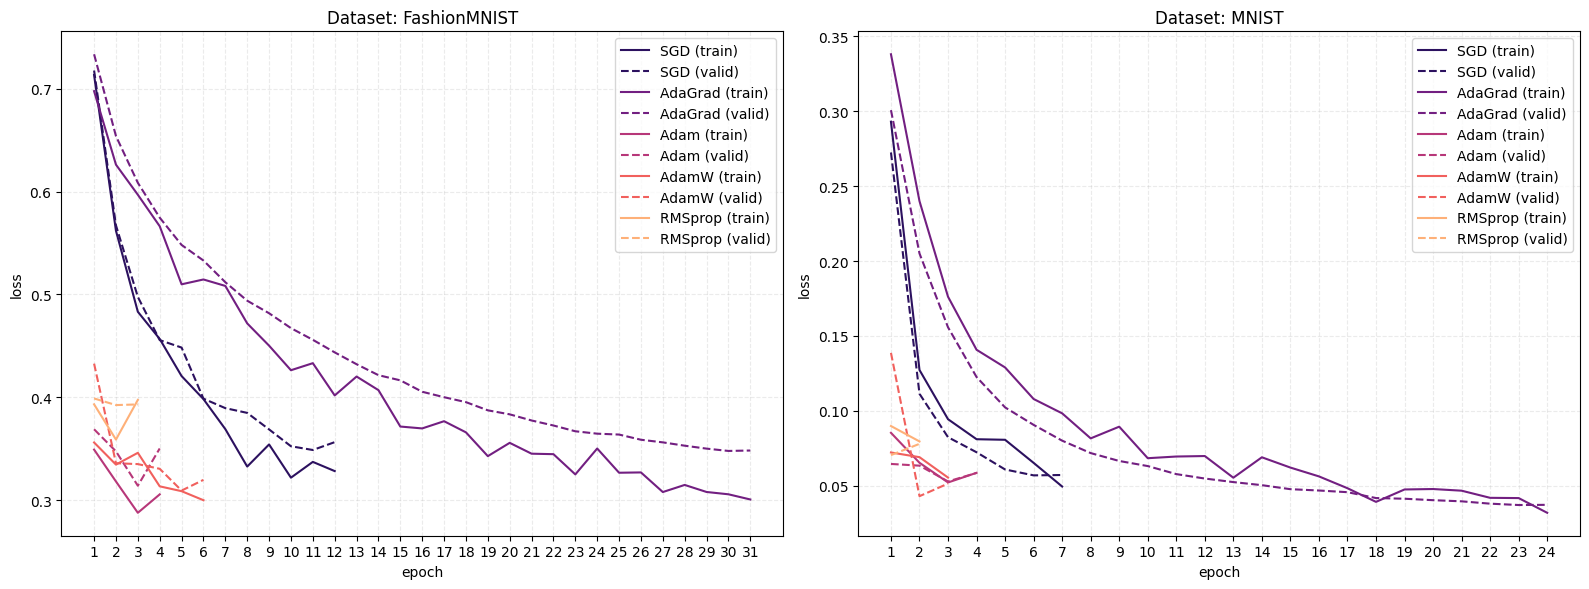

In [11]:
cols = len(datasets)
fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(8 * cols, 6), tight_layout=True)
colors = sns.color_palette("magma", len(optimizers))

for dataset_idx, (dataset_name, dataset) in enumerate(datasets.items()):
    max_epochs: int = 0
    for optimizer_idx, (optimizer_name, optimizer) in enumerate(optimizers.items()):
        results_df = pd.read_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv")
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["train_loss"],
            label=f"{optimizer_name} (train)",
            color=colors[optimizer_idx],
        )
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["valid_loss"],
            label=f"{optimizer_name} (valid)",
            color=colors[optimizer_idx],
            linestyle="--",
        )
        if len(results_df["epoch"]) > max_epochs:
            max_epochs = len(results_df["epoch"])

    ax[dataset_idx].set_title(f"Dataset: {dataset_name}")
    ax[dataset_idx].set_xticks(np.arange(1, max_epochs + 1, step=1))
    ax[dataset_idx].set_xlabel("epoch")
    ax[dataset_idx].set_ylabel("loss")
    ax[dataset_idx].grid(linestyle="--", alpha=0.25)
    ax[dataset_idx].legend()

fig.savefig(f"{RESULT_PATH}/plot_loss.png")